# Comparative Analysis of ONA, CMA, and DEMA Algorithms for Aethalometer Data

## 1. Introduction and Background

This notebook implements and compares three post-processing algorithms for micro-aethalometer data:
  
1. **Optimized Noise-reduction Algorithm (ONA)**: A method described by Hagler et al. (2011) that adaptively time-averages BC data based on incremental light attenuation (ΔATN).

2. **Centered Moving Average (CMA)**: A smoothing technique that incorporates data points both before and after each measurement to reduce noise while preserving microenvironmental characteristics.

3. **Double Exponentially Weighted Moving Average (DEMA)**: A smoothing approach that reduces noise-induced artifacts while limiting lag, especially useful for source apportionment calculations.
 
Both CMA and DEMA have been shown to outperform ONA for newer dual-spot aethalometers in recent research by Liu et al. (2021) and Mendoza et al. (2024).


## 2. Import Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from IPython.display import display

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 3. Load and Explore the Data
 
First, let's load the Aethalometer data and examine its structure.

In [18]:
# Define the file path - replace with your actual file path
file_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"  # Replace with your file path

# Check if pyarrow is available for optimal performance
try:
    import pyarrow
    use_pyarrow = True
except ImportError:
    print("Warning: pyarrow not found, using slower pandas conversion method")
    use_pyarrow = False

# Load the data with Polars
pl_data = pl.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {pl_data.shape}")
print("\nColumn names:")
print(pl_data.columns)

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(pl_data.head())

# Create a table to collect wavelength statistics
wavelength_stats = []
wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']

# Check for the presence of BC columns for each wavelength
for wavelength in wavelengths:
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    
    if bc_col in pl_data.columns:
        # Using Polars expressions for statistics
        stats = {}
        stats["Wavelength"] = wavelength
        
        # Get BC range
        bc_range = pl_data.select([
            pl.col(bc_col).min().alias("bc_min"),
            pl.col(bc_col).max().alias("bc_max")
        ])
        stats["BC Min (ng/m³)"] = int(bc_range[0, "bc_min"])
        stats["BC Max (ng/m³)"] = int(bc_range[0, "bc_max"])
        
        # Count negative values
        neg_count = pl_data.filter(pl.col(bc_col) < 0).height
        neg_percentage = (neg_count / pl_data.height) * 100
        stats["Negative BC Count"] = neg_count
        stats["Negative BC (%)"] = round(neg_percentage, 2)
        
        # Get ATN range if available
        if atn_col in pl_data.columns:
            atn_range = pl_data.select([
                pl.col(atn_col).min().alias("atn_min"),
                pl.col(atn_col).max().alias("atn_max")
            ])
            stats["ATN Min"] = float(atn_range[0, "atn_min"])
            stats["ATN Max"] = float(atn_range[0, "atn_max"])
        else:
            stats["ATN Min"] = None
            stats["ATN Max"] = None
        
        wavelength_stats.append(stats)
    else:
        print(f"\nWarning: {wavelength} data columns not found")

# Create a DataFrame from the statistics and explicitly set the data types
if wavelength_stats:
    stats_df = pl.DataFrame(wavelength_stats)
    
    # Ensure proper data types for better display
    stats_df = stats_df.with_columns([
        pl.col("Wavelength").cast(pl.Utf8),
        pl.col("BC Min (ng/m³)").cast(pl.Int64),
        pl.col("BC Max (ng/m³)").cast(pl.Int64),
        pl.col("Negative BC Count").cast(pl.Int64),
        pl.col("Negative BC (%)").cast(pl.Float64).round(2),
        pl.col("ATN Min").cast(pl.Float64).round(3),
        pl.col("ATN Max").cast(pl.Float64).round(3)
    ])
    
    print("\nWavelength Statistics:")
    
    # Convert to pandas for better display formatting
    import pandas as pd
    pd_stats = stats_df.to_pandas()
    
    # Format the display to remove quotes
    pd.set_option('display.precision', 2)
    display(pd_stats)

# Check the time resolution
if 'Timebase (s)' in pl_data.columns:
    timebase = pl_data.select(pl.col('Timebase (s)')).row(0)[0]
    print(f"\nInstrument timebase: {timebase} seconds")
else:
    print("\nTimebase column not found")

# Convert to pandas for compatibility with the rest of the notebook
# Use pyarrow if available for better performance
if use_pyarrow:
    data = pl_data.to_pandas()
else:
    # Fallback method if pyarrow is not available
    import pandas as pd
    data = pd.DataFrame({col: pl_data[col].to_numpy() for col in pl_data.columns})

Dataset shape: (1095086, 77)

Column names:
['Serial number', 'Time (UTC)', 'Datum ID', 'Session ID', 'Data format version', 'Firmware version', 'App version', 'Timezone offset (mins)', 'Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)', 'GPS lat (ddmm.mmmmm)', 'GPS long (dddmm.mmmmm)', 'GPS speed (km/h)', 'GPS sat count', 'Timebase (s)', 'Status', 'Battery remaining (%)', 'Accel X', 'Accel Y', 'Accel Z', 'Tape position', 'Flow setpoint (mL/min)', 'Flow total (mL/min)', 'Flow1 (mL/min)', 'Flow2 (mL/min)', 'Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 'Internal pressure (Pa)', 'Internal temp (C)', 'Optical config', 'UV Sen1', 'UV Sen2', 'UV Ref', 'UV ATN1', 'UV ATN2', 'UV K', 'Blue Sen1', 'Blue Sen2', 'Blue Ref', 'Blue ATN1', 'Blue ATN2', 'Blue K', 'Green Sen1', 'Green Sen2', 'Green Ref', 'Green ATN1', 'Green ATN2', 'Green K', 'Red Sen1', 'Red Sen2', 'Red Ref', 'Red ATN1', 'Red ATN2', 'Red K', 'IR Sen1', 'IR Sen2', 'IR Ref', 'IR ATN1', 'IR ATN2', 'IR K', 'UV BC1', 'UV BC2',

Serial number,Time (UTC),Datum ID,Session ID,Data format version,Firmware version,App version,Timezone offset (mins),Date local (yyyy/MM/dd),Time local (hh:mm:ss),GPS lat (ddmm.mmmmm),GPS long (dddmm.mmmmm),GPS speed (km/h),GPS sat count,Timebase (s),Status,Battery remaining (%),Accel X,Accel Y,Accel Z,Tape position,Flow setpoint (mL/min),Flow total (mL/min),Flow1 (mL/min),Flow2 (mL/min),Sample temp (C),Sample RH (%),Sample dewpoint (C),Internal pressure (Pa),Internal temp (C),Optical config,UV Sen1,UV Sen2,UV Ref,UV ATN1,UV ATN2,UV K,…,Blue ATN1,Blue ATN2,Blue K,Green Sen1,Green Sen2,Green Ref,Green ATN1,Green ATN2,Green K,Red Sen1,Red Sen2,Red Ref,Red ATN1,Red ATN2,Red K,IR Sen1,IR Sen2,IR Ref,IR ATN1,IR ATN2,IR K,UV BC1,UV BC2,UV BCc,Blue BC1,Blue BC2,Blue BCc,Green BC1,Green BC2,Green BCc,Red BC1,Red BC2,Red BCc,IR BC1,IR BC2,IR BCc,Readable status
str,str,i64,i64,i64,f64,f64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,f64,str,i64,i64,i64,f64,f64,f64,…,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""MA350-0238""","""2022-04-12T09:46:01Z""",26133,12,1,1.1,1.4,0,"""2022-04-12""","""9:46:01 AM""",0,0,0,0,60,64,100,-25746,-25,-1832,3,100,100.0,55.43,44.57,34.31,36.3,17.23,76676,34.69,"""DUALSPOT-UV-BLUE-GREEN-RED-IR""",929908,753627,927344,0.0,0.0,0.0,…,0.0,0.0,0.0,907135,929279,854529,0.0,0.0,0.0,899121,912953,905900,0.0,0.0,0.0,740292,835057,943997,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""NA"""
"""MA350-0238""","""2022-04-12T09:47:01Z""",26134,12,1,1.1,1.4,0,"""2022-04-12""","""9:47:01 AM""",0,0,0,0,60,64,100,-25728,-67,-1817,3,100,99.72,55.17,44.55,34.39,35.8,17.09,76524,34.81,"""DUALSPOT-UV-BLUE-GREEN-RED-IR""",929924,754408,930775,0.3611,0.26415,0.0,…,0.281023,0.214242,0.0,906407,929062,855921,0.242006,0.184309,0.0,900671,914944,909208,0.194509,0.147598,0.0,740555,835694,945694,0.143129,0.104529,0.0,19221,17414,19221,18880,17826,18880,18208,17175,18208,17685,16620,17685,18120,16389,18120,"""NA"""
"""MA350-0238""","""2022-04-12T09:48:01Z""",26135,12,1,1.1,1.4,0,"""2022-04-12""","""9:48:01 AM""",0,0,0,0,60,64,100,-25757,-64,-1842,3,100,99.82,55.42,44.4,34.47,35.4,16.97,76456,34.88,"""DUALSPOT-UV-BLUE-GREEN-RED-IR""",923594,749724,926448,0.588493,0.427177,0.0,…,0.452113,0.344497,0.0,908469,931527,859091,0.391238,0.296337,0.0,887264,901604,896698,0.314209,0.236612,0.0,736557,831342,941337,0.228694,0.166099,0.0,12050,10783,12050,11443,10874,11443,11178,10474,11178,10834,10057,10834,10784,9686,10784,"""NA"""
"""MA350-0238""","""2022-04-12T09:49:01Z""",26136,12,1,1.1,1.4,0,"""2022-04-12""","""9:49:01 AM""",0,0,0,0,60,64,100,-25739,-50,-1842,3,100,99.93,55.55,44.39,34.55,35.0,16.88,76428,35.0,"""DUALSPOT-UV-BLUE-GREEN-RED-IR""",924660,750829,928700,0.720298,0.525787,0.0,…,0.551754,0.422996,0.0,902690,925718,854310,0.474417,0.361931,0.0,898125,912753,908290,0.382261,0.287699,0.0,737633,832635,943188,0.278503,0.203642,0.0,6968,6524,6968,6648,6555,6648,6216,6134,6216,6145,5773,6145,6263,5908,6263,"""NA"""
"""MA350-0238""","""2022-04-12T09:50:01Z""",26137,12,1,1.1,1.4,0,"""2022-04-12""","""9:50:01 AM""",0,0,0,0,60,64,100,-25781,-92,-1844,3,100,99.98,55.25,44.74,34.64,34.7,16.8,76404,35.06,"""DUALSPOT-UV-BLUE-GREEN-RED-IR""",926648,752681,931922,0.855046,0.625255,0.0,…,0.652724,0.503337,0.0,905570,928891,857767,0.560921,0.429314,0.0,899095,913923,909873,0.450891,0.341063,0.0,738374,833573,944572,0.329212,0.242726,0.0,7163,6529,7163,6774,6656,6774,6499,6252,6499,6231,5983,6231,6411,6101,6411,"""NA"""



Wavelength Statistics:


,Wavelength,BC Min (ng/m³),BC Max (ng/m³),Negative BC Count,Negative BC (%),ATN Min,ATN Max
0,UV,-211848,509219,26701,2.44,0.0,100.43
1,Blue,-234329472,216328672,18394,1.68,0.0,88.14
2,Green,-366719,737819,19824,1.81,0.0,82.06
3,Red,-182273,583168,21969,2.01,0.0,73.40
4,IR,-149717,547607,30983,2.83,0.0,60.40



Instrument timebase: 60 seconds


## 4. ONA Algorithm Implementation
  
The Optimized Noise-reduction Algorithm (ONA) adaptively time-averages BC data based on incremental light attenuation (ΔATN).

In [24]:
def apply_ona_polars(data, wavelength='Blue', delta_atn_min=0.05):
    """
    Apply the Optimized Noise-reduction Algorithm to Aethalometer data (Polars implementation)
    
    Parameters:
    -----------
    data : polars.DataFrame
        DataFrame containing Aethalometer data with columns for timestamp, BC, and ATN values
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    delta_atn_min : float
        Minimum change in attenuation (ATN) required for averaging (default 0.05)
        
    Returns:
    --------
    data_smoothed : polars.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC and number of points averaged
    """
    # Create a copy of the input dataframe
    data_smoothed = data.clone()
    
    # Identify the columns for BC and ATN values based on wavelength
    bc_col = f"{wavelength} BCc"  # BCc column for this wavelength
    atn_col = f"{wavelength} ATN1"  # ATN1 column for this wavelength
    points_averaged_col = f"{wavelength}_points_averaged"
    smoothed_bc_col = f"{wavelength}_BC_ONA"
    
    # Check if ATN column exists
    if atn_col not in data_smoothed.columns:
        print(f"Warning: {atn_col} column not found. ONA algorithm cannot be applied.")
        # Add empty columns for consistency
        data_smoothed = data_smoothed.with_columns([
            pl.lit(1).alias(points_averaged_col),
            pl.col(bc_col).alias(smoothed_bc_col)
        ])
        return data_smoothed
    
    # Calculate absolute differences to identify filter changes
    data_smoothed = data_smoothed.with_columns([
        pl.col(atn_col).diff().abs().alias("temp"),
        pl.lit(1).alias(points_averaged_col),  # Initialize points averaged
        pl.col(bc_col).alias(smoothed_bc_col)  # Initialize smoothed BC
    ])
    
    # Find filter changes (large jumps in ATN)
    filter_changes = data_smoothed.filter(
        (pl.col("temp") > 30) | pl.col("temp").is_null()
    ).get_column(pl.col("temp").cumcount()).to_numpy()
    
    # Create filtchange array with start and end points
    if len(filter_changes) > 0:
        filtchange = np.zeros(len(filter_changes) + 2, dtype=int)
        filtchange[1:-1] = filter_changes
        filtchange[-1] = len(data_smoothed)
    else:
        filtchange = np.array([0, len(data_smoothed)], dtype=int)
    
    print(f"Number of filter changes detected for {wavelength}: {len(filter_changes)}")
    
    # Process each segment between filter changes
    # This part is still done with numpy/pandas due to its complexity
    # Convert to pandas for this operation
    pd_data = data_smoothed.to_pandas()
    
    for k in range(len(filtchange) - 1):
        j = filtchange[k] + 1  # Set to first point after filter change
        
        while j < filtchange[k+1]:
            # Current ATN value
            current_atn = pd_data[atn_col].iloc[j]
            
            # Find points where ATN increases by at most delta_atn_min
            end_idx = filtchange[k+1]
            search_range = pd_data[atn_col].iloc[j+1:end_idx]
            
            if len(search_range) > 0:
                # Find points where ATN <= current_atn + delta_atn_min
                des_ind = np.where(search_range <= current_atn + delta_atn_min)[0]
                
                if len(des_ind) > 0:
                    # Calculate range of points to average
                    end_j = min(j + des_ind[-1] + 1, len(pd_data))
                    
                    # Check that j < end_j and there is data to average
                    if j < end_j:
                        # Get the data slice
                        bc_slice = pd_data[bc_col].iloc[j:end_j]
                        
                        # Check if there is valid data to average
                        if len(bc_slice) > 0 and not bc_slice.isna().all():
                            # Calculate smoothed BC by averaging over the window
                            avg_bc = np.nanmean(bc_slice)
                            
                            # Apply the averaged BC value to all points in the window
                            row_indices = pd_data.index[j:end_j]
                            pd_data.loc[row_indices, smoothed_bc_col] = avg_bc
                            
                            # Record number of points used in averaging
                            pd_data.loc[row_indices, points_averaged_col] = end_j - j
                        
                    # Move j to next position after the current window
                    j = end_j
                else:
                    # If no suitable points found, move to next point
                    j += 1
            else:
                # If at the end of the data segment, move to next point
                j += 1
    
    # Convert back to Polars
    result_df = pl.from_pandas(pd_data)
    # Drop the temporary column
    result_df = result_df.drop("temp")
    
    return result_df

## 5. CMA Algorithm Implementation
  
The Centered Moving Average is a smoothing technique that uses data points both before and after each measurement.

In [25]:
def apply_cma_polars(data, wavelength='Blue', window_size=None):
    """
    Apply the Centered Moving Average algorithm to Aethalometer data (Polars implementation)
    
    Parameters:
    -----------
    data : polars.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    window_size : int or None
        Size of the moving average window (must be odd). If None, 
        will use a default based on the data's timebase
        
    Returns:
    --------
    data_smoothed : polars.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.clone()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    smoothed_bc_col = f"{wavelength}_BC_CMA"
    
    # Determine window size if not specified
    if window_size is None:
        if 'Timebase (s)' in data_smoothed.columns:
            timebase = data_smoothed.select(pl.col('Timebase (s)')).row(0)[0]
            if timebase == 1:
                window_size = 11  # 11 seconds for 1-second data
            elif timebase == 5:
                window_size = 5   # 25 seconds for 5-second data
            elif timebase == 60:
                window_size = 3   # 3 minutes for 1-minute data
            else:
                window_size = 5   # Default for other timebases
        else:
            window_size = 5       # Default if timebase is unknown
    
    # Make sure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    print(f"Using window size of {window_size} for CMA on {wavelength}")
    
    # Apply rolling mean with center=True
    data_smoothed = data_smoothed.with_columns(
        pl.col(bc_col).rolling_mean(
            window_size=window_size,
            center=True,
            min_samples=1  # Updated from min_periods to min_samples
        ).alias(smoothed_bc_col)
    )
    
    return data_smoothed

## 6. DEMA Algorithm Implementation
 
The Double Exponentially Weighted Moving Average applies additional smoothing to an EMA to reduce noise while limiting lag.

In [26]:
def apply_dema_polars(data, wavelength='Blue', alpha=None):
    """
    Apply the Double Exponentially Weighted Moving Average algorithm (Polars implementation)
    
    Parameters:
    -----------
    data : polars.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    alpha : float
        Smoothing parameter (between 0 and 1)
        For 60s data, 0.125 approximates a 15-minute smoothing window
        
    Returns:
    --------
    data_smoothed : polars.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.clone()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    ema_col = f"{wavelength}_EMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Set the smoothing parameter based on timebase if not explicitly provided
    if 'Timebase (s)' in data_smoothed.columns:
        timebase = data_smoothed.select(pl.col('Timebase (s)')).row(0)[0]
        if alpha is None:
            # Use formula 2/(N+1) where N is the desired smoothing period
            if timebase == 1:
                # Default to approximate 5-minute window for 1-second data
                N = 300 / timebase
            elif timebase == 5:
                # Default to approximate 5-minute window for 5-second data
                N = 300 / timebase
            elif timebase == 60:
                # Default to approximate 15-minute window for 60-second data
                N = 900 / timebase
            else:
                N = 15  # Default for other timebases
                
            alpha = 2 / (N + 1)
    else:
        # Default alpha if timebase is unknown
        if alpha is None:
            alpha = 0.125
    
    print(f"Using alpha of {alpha:.4f} for DEMA on {wavelength}")
    
    # First EMA calculation
    data_smoothed = data_smoothed.with_columns(
        pl.col(bc_col).ewm_mean(alpha=alpha, adjust=False).alias(ema_col)
    )
    
    # Second EMA calculation (EMA of EMA)
    data_smoothed = data_smoothed.with_columns(
        pl.col(ema_col).ewm_mean(alpha=alpha, adjust=False).alias("ema_of_ema")
    )
    
    # Calculate DEMA: (2 * EMA) - EMA(EMA)
    data_smoothed = data_smoothed.with_columns(
        (2 * pl.col(ema_col) - pl.col("ema_of_ema")).alias(dema_col)
    )
    
    # Drop the temporary ema_of_ema column
    data_smoothed = data_smoothed.drop("ema_of_ema")
    
    return data_smoothed

## 7. Apply All Processing Methods to Data

In [ ]:
# Create separate dataframes for each method using Polars
pl_processed_data_raw = pl_data.clone()
pl_processed_data_ona = pl_data.clone()
pl_processed_data_cma = pl_data.clone()
pl_processed_data_dema = pl_data.clone()

# Set the minimum change in attenuation (ΔATN) for ONA
delta_atn_min = 0.05  # Default value from the Hagler paper

# Process each wavelength with all methods
for wavelength in wavelengths:
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    
    if bc_col in pl_processed_data_raw.columns:
        # Apply ONA if ATN column exists
        if atn_col in pl_processed_data_raw.columns:
            print(f"\nApplying ONA to {wavelength} wavelength data...")
            pl_processed_data_ona = apply_ona_polars(pl_processed_data_ona, wavelength, delta_atn_min)
        
        # Apply CMA
        print(f"\nApplying CMA to {wavelength} wavelength data...")
        pl_processed_data_cma = apply_cma_polars(pl_processed_data_cma, wavelength)
        
        # Apply DEMA
        print(f"\nApplying DEMA to {wavelength} wavelength data...")
        pl_processed_data_dema = apply_dema_polars(pl_processed_data_dema, wavelength)

# Convert to pandas for compatibility with downstream functions if needed
processed_data_raw = pl_processed_data_raw.to_pandas()
processed_data_ona = pl_processed_data_ona.to_pandas()
processed_data_cma = pl_processed_data_cma.to_pandas()
processed_data_dema = pl_processed_data_dema.to_pandas()


Applying ONA to UV wavelength data...
Number of filter changes detected for UV: 815

Applying CMA to UV wavelength data...
Using window size of 3 for CMA on UV

Applying DEMA to UV wavelength data...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_9541/2932457420.py:53: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  pl.col(bc_col).rolling_mean(


Using alpha of 0.1250 for DEMA on UV

Applying ONA to Blue wavelength data...
Number of filter changes detected for Blue: 814

Applying CMA to Blue wavelength data...
Using window size of 3 for CMA on Blue

Applying DEMA to Blue wavelength data...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_9541/2932457420.py:53: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  pl.col(bc_col).rolling_mean(


Using alpha of 0.1250 for DEMA on Blue

Applying ONA to Green wavelength data...
Number of filter changes detected for Green: 813

Applying CMA to Green wavelength data...
Using window size of 3 for CMA on Green

Applying DEMA to Green wavelength data...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_9541/2932457420.py:53: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  pl.col(bc_col).rolling_mean(


Using alpha of 0.1250 for DEMA on Green

Applying ONA to Red wavelength data...
Number of filter changes detected for Red: 812

Applying CMA to Red wavelength data...
Using window size of 3 for CMA on Red

Applying DEMA to Red wavelength data...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_9541/2932457420.py:53: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  pl.col(bc_col).rolling_mean(


Using alpha of 0.1250 for DEMA on Red

Applying ONA to IR wavelength data...
Number of filter changes detected for IR: 809

Applying CMA to IR wavelength data...
Using window size of 3 for CMA on IR

Applying DEMA to IR wavelength data...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_9541/2932457420.py:53: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  pl.col(bc_col).rolling_mean(


Using alpha of 0.1250 for DEMA on IR


## 8. Calculate Source Apportionment
 
Following the recommendations from recent research, we'll implement source apportionment calculations using the Aethalometer model for each processing method.

In [28]:
def calculate_source_apportionment(data, aae_wb=2.0, aae_ff=1.0):
    """
    Calculate source apportionment using the Aethalometer Model
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with BC data at blue and IR wavelengths
    aae_wb : float
        Absorption Ångström Exponent for wood burning (default 2.0)
    aae_ff : float
        Absorption Ångström Exponent for fossil fuel (default 1.0)
    
    Returns:
    --------
    data_sa : pandas.DataFrame
        DataFrame with additional source apportionment columns
    """
    # Create a copy of the input dataframe
    data_sa = data.copy()
    
    # Convert to Polars for faster calculations
    pl_data = pl.from_pandas(data[['Blue BCc', 'IR BCc']])
    
    # Constants
    mac_blue = 10.12  # m²/g at 470nm
    mac_ir = 7.77     # m²/g at 880nm
    c_ref = 1.3       # Multiple scattering enhancement factor
    wavelength_ratio = 470 / 880
    
    # Calculate absorption coefficients
    pl_data = pl_data.with_columns(
        (pl.col('Blue BCc') * mac_blue / c_ref).alias('Babs_Blue'),
        (pl.col('IR BCc') * mac_ir / c_ref).alias('Babs_IR')
    )
    
    # Calculate absorption coefficients for wood burning and fossil fuel at IR wavelength
    pl_data = pl_data.with_columns(
        ((pl.col('Babs_Blue') - pl.col('Babs_IR') * (wavelength_ratio ** (-aae_wb))) / 
        ((wavelength_ratio ** (-aae_ff)) - (wavelength_ratio ** (-aae_wb)))).alias('Babs_FF_IR')
    )
    
    pl_data = pl_data.with_columns(
        (pl.col('Babs_IR') - pl.col('Babs_FF_IR')).alias('Babs_WB_IR')
    )
    
    # Calculate BB% (biomass burning percentage)
    pl_data = pl_data.with_columns(
        (100 * pl.col('Babs_WB_IR') / pl.col('Babs_IR')).alias('BB_Percent')
    )
    
    # Handle infinity and NaN values
    pl_data = pl_data.with_columns(
        pl.when(pl.col('BB_Percent').is_infinite() | pl.col('BB_Percent').is_nan())
        .then(pl.lit(0))
        .otherwise(pl.col('BB_Percent'))
        .alias('BB_Percent')
    )
    
    # Calculate BC from wood burning and fossil fuel
    pl_data = pl_data.with_columns(
        (pl.col('IR BCc') * pl.col('BB_Percent') / 100).alias('BC_WB'),
        (pl.col('IR BCc') * (100 - pl.col('BB_Percent')) / 100).alias('BC_FF')
    )
    
    # Convert back to pandas DataFrame
    for col in pl_data.columns:
        if col not in data_sa.columns:
            data_sa[col] = pl_data[col].to_numpy()
    
    return data_sa

In [29]:
def apply_dema_to_source_apportionment(data, alpha=0.125):
    """
    Apply DEMA specifically to source apportionment results
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with source apportionment data
    alpha : float
        Smoothing parameter
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with smoothed source apportionment data
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Apply DEMA to BB_Percent
    if 'BB_Percent' in data_smoothed.columns:
        # Convert to Polars for faster calculations
        pl_data = pl.from_pandas(data_smoothed[['BB_Percent']])
        
        # First EMA
        pl_data = pl_data.with_columns(
            pl.col('BB_Percent').ewm_mean(alpha=alpha, adjust=False).alias('BB_Percent_EMA')
        )
        
        # Calculate DEMA
        pl_data = pl_data.with_columns(
            pl.col('BB_Percent_EMA').ewm_mean(alpha=alpha, adjust=False).alias('ema_of_ema')
        )
        
        pl_data = pl_data.with_columns(
            (2 * pl.col('BB_Percent_EMA') - pl.col('ema_of_ema')).alias('BB_Percent_DEMA')
        )
        
        # Limit BB% to logical range [0, 100]
        pl_data = pl_data.with_columns(
            pl.col('BB_Percent_DEMA').clip(0, 100).alias('BB_Percent_DEMA')
        )
        
        # Add the calculated columns back to the pandas DataFrame
        data_smoothed['BB_Percent_EMA'] = pl_data['BB_Percent_EMA'].to_numpy()
        data_smoothed['BB_Percent_DEMA'] = pl_data['BB_Percent_DEMA'].to_numpy()
        
        # Recalculate BC_WB and BC_FF using smoothed BB_Percent
        if 'IR_BC_CMA' in data_smoothed.columns:
            bc_ir = data_smoothed['IR_BC_CMA']
        elif 'IR_BC_DEMA' in data_smoothed.columns:
            bc_ir = data_smoothed['IR_BC_DEMA']
        elif 'IR_BC_ONA' in data_smoothed.columns:
            bc_ir = data_smoothed['IR_BC_ONA']
        else:
            bc_ir = data_smoothed['IR BCc']
            
        data_smoothed['BC_WB_DEMA'] = bc_ir * data_smoothed['BB_Percent_DEMA'] / 100
        data_smoothed['BC_FF_DEMA'] = bc_ir * (100 - data_smoothed['BB_Percent_DEMA']) / 100
    
    return data_smoothed

In [30]:
# Calculate source apportionment for raw data
print("\nCalculating source apportionment for raw data...")
processed_data_raw_sa = calculate_source_apportionment(processed_data_raw)

# Calculate source apportionment for ONA-processed data
if 'Blue_BC_ONA' in processed_data_ona.columns and 'IR_BC_ONA' in processed_data_ona.columns:
    print("\nCalculating source apportionment for ONA-processed data...")
    processed_data_ona_sa = processed_data_ona.copy()
    # Use the ONA-processed data for source apportionment
    processed_data_ona_sa['Blue BCc'] = processed_data_ona['Blue_BC_ONA']
    processed_data_ona_sa['IR BCc'] = processed_data_ona['IR_BC_ONA']
    processed_data_ona_sa = calculate_source_apportionment(processed_data_ona_sa)
else:
    processed_data_ona_sa = processed_data_raw_sa.copy()
    print("\nWarning: ONA-processed data not available for both Blue and IR wavelengths, using raw data for source apportionment")

# Calculate source apportionment for CMA-processed data
print("\nCalculating source apportionment for CMA-processed data...")
processed_data_cma_sa = processed_data_cma.copy()
# Use the CMA-processed data for source apportionment
processed_data_cma_sa['Blue BCc'] = processed_data_cma['Blue_BC_CMA']
processed_data_cma_sa['IR BCc'] = processed_data_cma['IR_BC_CMA']
processed_data_cma_sa = calculate_source_apportionment(processed_data_cma_sa)

# Calculate source apportionment for DEMA-processed data
print("\nCalculating source apportionment for DEMA-processed data...")
processed_data_dema_sa = processed_data_dema.copy()
# Use the DEMA-processed data for source apportionment
processed_data_dema_sa['Blue BCc'] = processed_data_dema['Blue_BC_DEMA']
processed_data_dema_sa['IR BCc'] = processed_data_dema['IR_BC_DEMA'] 
processed_data_dema_sa = calculate_source_apportionment(processed_data_dema_sa)


Calculating source apportionment for raw data...

Calculating source apportionment for ONA-processed data...

Calculating source apportionment for CMA-processed data...

Calculating source apportionment for DEMA-processed data...


## 9. Evaluate Processing Performance
  
Now let's evaluate how well each processing method performed and compare them.

In [31]:
def evaluate_processing(data_raw, data_processed, raw_col, processed_col):
    """
    Evaluate the performance of a processing algorithm
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with original data
    data_processed : pandas.DataFrame
        DataFrame with processed data
    raw_col : str
        Column name for raw data
    processed_col : str
        Column name for processed data
        
    Returns:
    --------
    metrics : dict
        Dictionary of performance metrics
    """
    # Convert to Polars for faster calculations
    pl_raw = pl.from_pandas(data_raw[[raw_col]])
    pl_processed = pl.from_pandas(data_processed[[processed_col]])
    
    # 1. Reduction of negatives
    numneg_raw = pl_raw.filter(pl.col(raw_col) < 0).height / pl_raw.height
    numneg_processed = pl_processed.filter(pl.col(processed_col) < 0).height / pl_processed.height
    
    print(f"Fraction of negative values in raw data: {numneg_raw:.4f}")
    print(f"Fraction of negative values after processing: {numneg_processed:.4f}")
    
    if numneg_raw > 0:
        reduction = (numneg_raw - numneg_processed)/numneg_raw
        print(f"Reduction in negative values: {reduction:.4f} ({reduction*100:.1f}%)")
    else:
        reduction = 0
        print("No negative values in raw data to reduce")
    
    # 2. Reduction of noise (average absolute difference between consecutive points)
    # This is a bit complex with Polars, let's use Pandas/NumPy for this part
    temp_raw = np.abs(np.diff(data_raw[raw_col].values))
    temp_processed = np.abs(np.diff(data_processed[processed_col].values))
    
    noise_raw = np.nanmean(temp_raw)
    noise_processed = np.nanmean(temp_processed)
    
    print(f"Noise in raw data: {noise_raw:.1f} ng/m³")
    print(f"Noise in processed data: {noise_processed:.1f} ng/m³")
    print(f"Noise reduction factor: {noise_raw/noise_processed:.1f}x")
    
    # 3. Calculate correlation with raw data
    # Create a combined Polars DataFrame
    pl_combined = pl.from_pandas(pd.DataFrame({
        'raw': data_raw[raw_col],
        'processed': data_processed[processed_col]
    }))
    
    correlation = pl_combined.select(
        pl.corr('raw', 'processed').alias('correlation')
    )[0, 0]
    
    print(f"Correlation with raw data: {correlation:.4f}")
    
    return {
        'negative_original': numneg_raw,
        'negative_processed': numneg_processed,
        'negative_reduction': reduction,
        'noise_original': noise_raw,
        'noise_processed': noise_processed,
        'noise_reduction': noise_raw/noise_processed,
        'correlation': correlation
    }

In [32]:
# Evaluate each wavelength and method
summary_metrics = {}

for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if bc_col in data.columns:
        print(f"\n===== Performance Evaluation for {wavelength} Wavelength =====")
        
        # Evaluate ONA if available
        if ona_col in processed_data_ona.columns:
            print(f"\nEvaluating ONA for {wavelength} wavelength:")
            summary_metrics[f"{wavelength}_ONA"] = evaluate_processing(data, processed_data_ona, bc_col, ona_col)
        
        # Evaluate CMA
        print(f"\nEvaluating CMA for {wavelength} wavelength:")
        summary_metrics[f"{wavelength}_CMA"] = evaluate_processing(data, processed_data_cma, bc_col, cma_col)
        
        # Evaluate DEMA
        print(f"\nEvaluating DEMA for {wavelength} wavelength:")
        summary_metrics[f"{wavelength}_DEMA"] = evaluate_processing(data, processed_data_dema, bc_col, dema_col)

# Create a summary table
summary_table = pd.DataFrame.from_dict(summary_metrics, orient='index')
summary_table.columns = [
    'Negative values (original)',
    'Negative values (processed)', 
    'Negative reduction',
    'Noise (original ng/m³)', 
    'Noise (processed ng/m³)',
    'Noise reduction factor',
    'Correlation with raw'
]

# Display the summary table
print("\n===== Summary of Method Performance =====")
display(summary_table)

# Compare Source Apportionment Results
print("\n===== Source Apportionment Comparison =====")
print("\nComparison of BB% from Raw, ONA, CMA and DEMA processing:")
print(f"Raw data - Mean BB%: {processed_data_raw_sa['BB_Percent'].mean():.2f}, Std: {processed_data_raw_sa['BB_Percent'].std():.2f}")

if 'BB_Percent' in processed_data_ona_sa.columns:
    print(f"ONA data - Mean BB%: {processed_data_ona_sa['BB_Percent'].mean():.2f}, Std: {processed_data_ona_sa['BB_Percent'].std():.2f}")

print(f"CMA data - Mean BB%: {processed_data_cma_sa['BB_Percent'].mean():.2f}, Std: {processed_data_cma_sa['BB_Percent'].std():.2f}")
print(f"DEMA data - Mean BB%: {processed_data_dema_sa['BB_Percent'].mean():.2f}, Std: {processed_data_dema_sa['BB_Percent'].std():.2f}")


===== Performance Evaluation for Blue Wavelength =====

Evaluating ONA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after processing: 0.0033
Reduction in negative values: 0.8053 (80.5%)
Noise in raw data: 4008.2 ng/m³
Noise in processed data: 3288.5 ng/m³
Noise reduction factor: 1.2x
Correlation with raw data: 0.9874

Evaluating CMA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after processing: 0.0029
Reduction in negative values: 0.8301 (83.0%)
Noise in raw data: 4008.2 ng/m³
Noise in processed data: 1506.8 ng/m³
Noise reduction factor: 2.7x
Correlation with raw data: 0.0612

Evaluating DEMA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after processing: 0.0014
Reduction in negative values: 0.9154 (91.5%)
Noise in raw data: 4008.2 ng/m³
Noise in processed data: 791.3 ng/m³
Noise reduction factor: 5.1x
Correlation with raw data: 0.6

,Negative values (original),Negative values (processed),Negative reduction,Noise (original ng/m³),Noise (processed ng/m³),Noise reduction factor,Correlation with raw
Blue_ONA,0.02,3.27e-03,0.81,4008.16,3288.51,1.22,0.99
Blue_CMA,0.02,2.85e-03,0.83,4008.16,1506.84,2.66,0.06
Blue_DEMA,0.02,1.42e-03,0.92,4008.16,791.32,5.07,0.69
IR_ONA,0.03,3.91e-03,0.86,2822.54,1930.31,1.46,0.99
IR_CMA,0.03,5.05e-03,0.82,2822.54,1057.81,2.67,0.95
IR_DEMA,0.03,2.12e-03,0.92,2822.54,578.18,4.88,0.93



===== Source Apportionment Comparison =====

Comparison of BB% from Raw, ONA, CMA and DEMA processing:
Raw data - Mean BB%: -26.47, Std: 3375.76
ONA data - Mean BB%: -27.29, Std: 2648.21
CMA data - Mean BB%: -28.72, Std: 1912.86
DEMA data - Mean BB%: -29.44, Std: 1113.76


## 10. Visualize Results
  
Let's visualize the raw and processed data to see the effects of our algorithms.

In [33]:
def plot_comparison(data, data_ona, data_cma, data_dema, wavelength, sample_period=None):
    """
    Plot the raw, ONA, CMA, and DEMA processed BC data for comparison
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Check which methods are available
    methods_available = []
    if bc_col in data.columns:
        methods_available.append(('Raw', data, bc_col, 'k-'))
    if ona_col in data_ona.columns:
        methods_available.append(('ONA', data_ona, ona_col, 'b-'))
    if cma_col in data_cma.columns:
        methods_available.append(('CMA', data_cma, cma_col, 'r-'))
    if dema_col in data_dema.columns:
        methods_available.append(('DEMA', data_dema, dema_col, 'g-'))
    
    # If no methods are available, return early
    if not methods_available:
        print(f"No data available for {wavelength} wavelength comparison")
        return
    
    # Use Polars for the data selection and transformation
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_datas = []
        
        for name, df, col, style in methods_available:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_datas.append((name, pl_slice.to_pandas(), col, style))
    else:
        plot_datas = methods_available
    
    # Create a figure
    plt.figure(figsize=(12, 6))
    
    # Create x-axis values - use first dataset for reference
    if len(plot_datas) > 0 and 'Time (UTC)' in plot_datas[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_datas[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            plt.gca().xaxis.set_major_formatter(x_formatter)
            plt.gcf().autofmt_xdate()
            x_label = 'Time (UTC)'
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_datas[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_datas[0][1]) if len(plot_datas) > 0 else 0)
        x_label = 'Data Point'
    
    # Plot BC data for each method
    for name, df, col, style in plot_datas:
        if name == 'Raw':
            plt.plot(x, df[col], style, alpha=0.5, label=name)
        else:
            plt.plot(x, df[col], style, label=name)
    
    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel(f'{wavelength} BC (ng/m³)')
    plt.title(f'Comparison of Noise Reduction Methods for {wavelength} Wavelength')
    
    # Add legend and grid
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Improve layout
    plt.tight_layout()
    
    # Get y-limits based on data to ensure consistent scaling
    if len(plot_datas) > 0:
        all_values = []
        for _, df, col, _ in plot_datas:
            all_values.extend(df[col].dropna().tolist())
        
        if all_values:
            # Use percentiles to avoid extreme outliers
            ymin = np.percentile(all_values, 1)  # 1st percentile
            ymax = np.percentile(all_values, 99)  # 99th percentile
            
            # Add a small buffer
            y_range = ymax - ymin
            plt.ylim([ymin - 0.05 * y_range, ymax + 0.05 * y_range])
    
    # Show the plot
    plt.show()
    
    # Optional: Calculate and display statistics for each method
    if len(plot_datas) > 0:
        # Use Polars for efficient stats calculation
        stats_data = []
        for name, df, col, _ in plot_datas:
            pl_df = pl.from_pandas(df[[col]])
            stats = pl_df.select([
                pl.lit(name).alias("Method"),
                pl.col(col).mean().alias("Mean"),
                pl.col(col).median().alias("Median"),
                pl.col(col).min().alias("Min"),
                pl.col(col).max().alias("Max"),
                pl.col(col).std().alias("Std Dev")
            ])
            stats_data.append(stats)
        
        if stats_data:
            # Combine all stats
            combined_stats = pl.concat(stats_data)
            
            # Display the statistics
            print(f"\nStatistics for {wavelength} wavelength:")
            display(combined_stats)

In [34]:
def plot_source_apportionment_comparison(data_raw, data_ona, data_cma, data_dema, sample_period=None):
    """
    Plot the source apportionment results for raw, ONA, CMA and DEMA data
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Check which methods have source apportionment data
    methods_available = []
    if 'BB_Percent' in data_raw.columns:
        methods_available.append(('Raw', data_raw, 'BB_Percent', 'k-'))
    if 'BB_Percent' in data_ona.columns:
        methods_available.append(('ONA', data_ona, 'BB_Percent', 'b-'))
    if 'BB_Percent' in data_cma.columns:
        methods_available.append(('CMA', data_cma, 'BB_Percent', 'r-'))
    if 'BB_Percent' in data_dema.columns:
        methods_available.append(('DEMA', data_dema, 'BB_Percent', 'g-'))
    
    # If no methods available, return early
    if not methods_available:
        print("No source apportionment data available for comparison")
        return
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_datas = []
        
        for name, df, col, style in methods_available:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_datas.append((name, pl_slice.to_pandas(), col, style))
    else:
        plot_datas = methods_available
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # Create x-axis values - use first dataset for reference
    if len(plot_datas) > 0 and 'Time (UTC)' in plot_datas[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_datas[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_datas[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_datas[0][1]) if len(plot_datas) > 0 else 0)
        x_label = 'Data Point'
    
    # Get y-limits for biomass burning percentage
    bb_values = []
    for name, df, col, _ in plot_datas:
        bb_values.extend(df[col].dropna().tolist())
    
    if bb_values:
        # Use percentiles to avoid extreme outliers but ensure range is within 0-100%
        bb_min = max(0, np.percentile(bb_values, 1))  # 1st percentile
        bb_max = min(100, np.percentile(bb_values, 99))  # 99th percentile
        
        # Add a small buffer
        bb_range = bb_max - bb_min
        bb_ylim = [max(0, bb_min - 0.05 * bb_range), min(100, bb_max + 0.05 * bb_range)]
        
        # Set y-limits for BB percentage plot
        axes[0].set_ylim(bb_ylim)
    
    # Plot BB percentage for each method
    for name, df, col, style in plot_datas:
        if name == 'Raw':
            axes[0].plot(x, df[col], style, alpha=0.5, label=name)
        else:
            axes[0].plot(x, df[col], style, label=name)
    
    axes[0].set_ylabel('Biomass Burning %')
    axes[0].set_title('Source Apportionment Results Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Get wood burning BC values for y-limits
    wb_values = []
    for name, df, _, _ in plot_datas:
        if 'BC_WB' in df.columns:
            wb_values.extend(df['BC_WB'].dropna().tolist())
    
    if wb_values:
        # Set y-limits for wood burning BC plot
        wb_min = np.percentile(wb_values, 1)  # 1st percentile
        wb_max = np.percentile(wb_values, 99)  # 99th percentile
        
        # Add a small buffer
        wb_range = wb_max - wb_min
        axes[1].set_ylim([max(0, wb_min - 0.05 * wb_range), wb_max + 0.05 * wb_range])
    
    # Plot Wood Burning BC for each method
    for name, df, _, style in plot_datas:
        if 'BC_WB' in df.columns:
            if name == 'Raw':
                axes[1].plot(x, df['BC_WB'], style, alpha=0.5, label=name)
            else:
                axes[1].plot(x, df['BC_WB'], style, label=name)
    
    axes[1].set_ylabel('Wood Burning BC (ng/m³)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Get fossil fuel BC values for y-limits
    ff_values = []
    for name, df, _, _ in plot_datas:
        if 'BC_FF' in df.columns:
            ff_values.extend(df['BC_FF'].dropna().tolist())
    
    if ff_values:
        # Set y-limits for fossil fuel BC plot
        ff_min = np.percentile(ff_values, 1)  # 1st percentile
        ff_max = np.percentile(ff_values, 99)  # 99th percentile
        
        # Add a small buffer
        ff_range = ff_max - ff_min
        axes[2].set_ylim([max(0, ff_min - 0.05 * ff_range), ff_max + 0.05 * ff_range])
    
    # Plot Fossil Fuel BC for each method
    for name, df, _, style in plot_datas:
        if 'BC_FF' in df.columns:
            if name == 'Raw':
                axes[2].plot(x, df['BC_FF'], style, alpha=0.5, label=name)
            else:
                axes[2].plot(x, df['BC_FF'], style, label=name)
    
    axes[2].set_ylabel('Fossil Fuel BC (ng/m³)')
    axes[2].set_xlabel(x_label)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Optional: Calculate and display statistics for each source apportionment component
    if len(plot_datas) > 0:
        # Use Polars for efficient stats calculation
        components = ['BB_Percent', 'BC_WB', 'BC_FF']
        stats_data = []
        
        for name, df, _, _ in plot_datas:
            for component in components:
                if component in df.columns:
                    pl_df = pl.from_pandas(df[[component]])
                    stats = pl_df.select([
                        pl.lit(name).alias("Method"),
                        pl.lit(component).alias("Component"),
                        pl.col(component).mean().alias("Mean"),
                        pl.col(component).median().alias("Median"),
                        pl.col(component).min().alias("Min"),
                        pl.col(component).max().alias("Max"),
                        pl.col(component).std().alias("Std Dev")
                    ])
                    stats_data.append(stats)
        
        if stats_data:
            # Combine all stats
            combined_stats = pl.concat(stats_data)
            
            # Display the statistics
            print("\nSource Apportionment Statistics:")
            display(combined_stats)

Let's plot the comparison of all methods for each wavelength


Plots for Blue wavelength comparison:


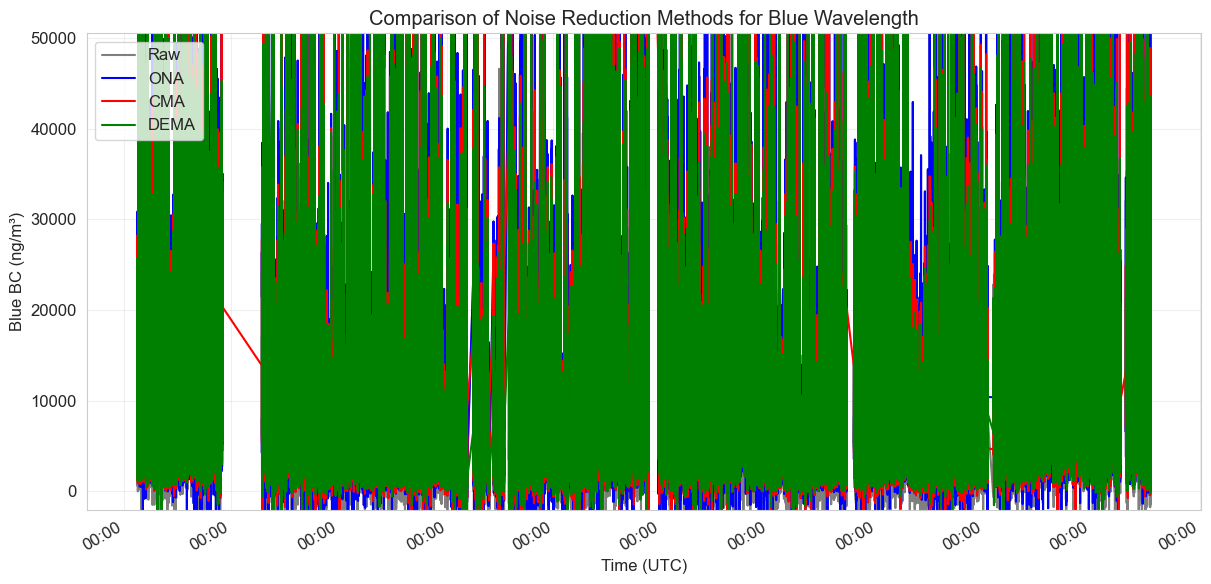


Statistics for Blue wavelength:


Method,Mean,Median,Min,Max,Std Dev
str,f64,f64,f64,f64,f64
"""Raw""",8491.342376,5588.0,-2.3433e8,2.16328672e8,318067.804079
"""ONA""",8490.511512,5509.0,-2.3433e8,2.16328672e8,314036.011793
"""CMA""",8490.510609,5621.666667,-7.6084534e7,6.1521e7,115301.140692
"""DEMA""",8491.341611,5629.600524,-5.1429e7,1.1565e7,70318.902527



Zoomed view of first 1000 points:


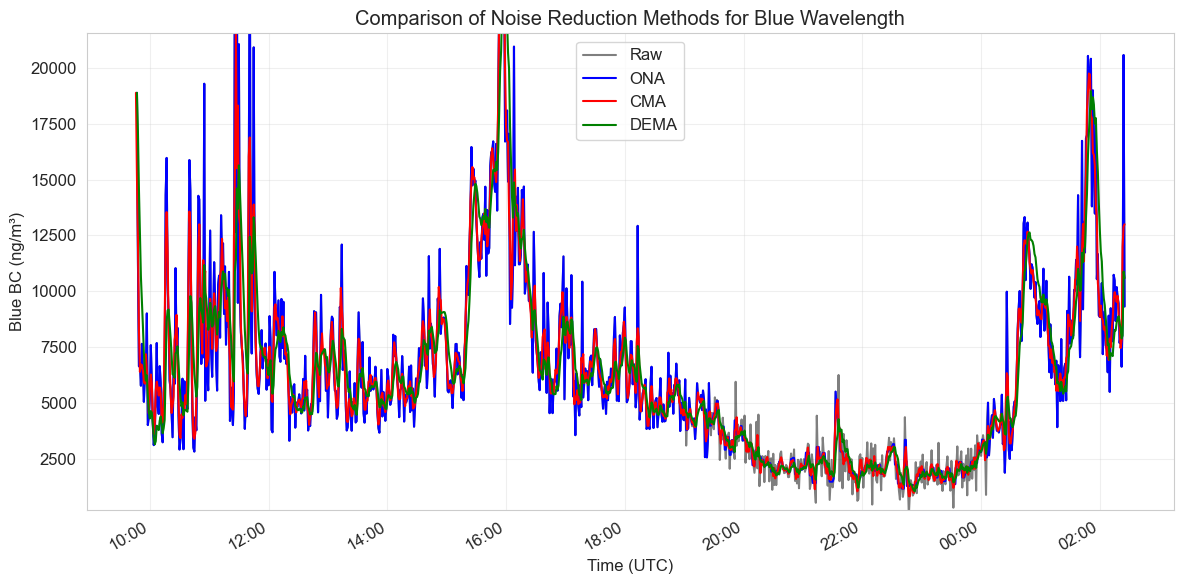


Statistics for Blue wavelength:


Method,Mean,Median,Min,Max,Std Dev
str,f64,f64,f64,f64,f64
"""Raw""",6286.578579,5549.0,-14.0,30867.0,4203.535027
"""ONA""",6286.578579,5515.0,1181.666667,30867.0,4189.846786
"""CMA""",6297.858167,5575.333333,837.666667,28243.666667,3932.702108
"""DEMA""",6283.139629,5746.332602,1061.7537,25773.487341,3868.1774



Plots for IR wavelength comparison:


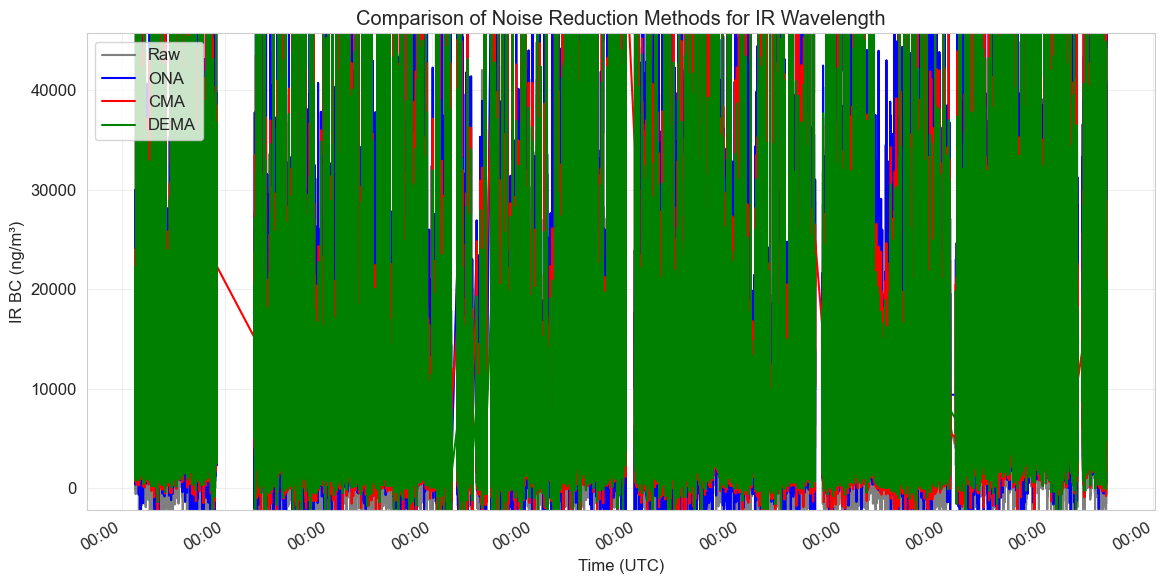


Statistics for IR wavelength:


Method,Mean,Median,Min,Max,Std Dev
str,f64,f64,f64,f64,f64
"""Raw""",8137.540267,5523.0,-149717.0,547607.0,9016.106429
"""ONA""",8136.566696,5354.0,-149717.0,547607.0,8893.026069
"""CMA""",8136.724637,5543.333333,-45458.333333,364823.666667,8547.660178
"""DEMA""",8137.537751,5556.127436,-24188.400226,214321.506166,8455.235615



Zoomed view of first 1000 points:


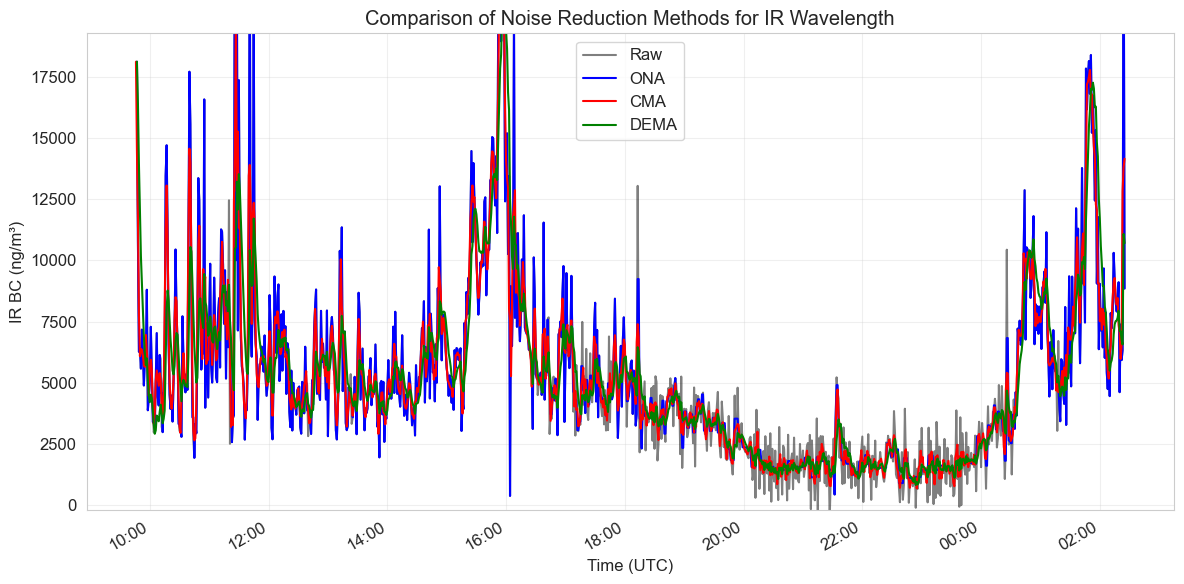


Statistics for IR wavelength:


Method,Mean,Median,Min,Max,Std Dev
str,f64,f64,f64,f64,f64
"""Raw""",5218.687688,4464.0,-577.0,29964.0,3855.138772
"""ONA""",5218.687688,4393.0,370.0,29964.0,3801.736787
"""CMA""",5229.878,4613.0,676.666667,24004.0,3480.070072
"""DEMA""",5211.230327,4621.302718,815.561464,22281.906269,3369.841106



Source apportionment comparison plots:


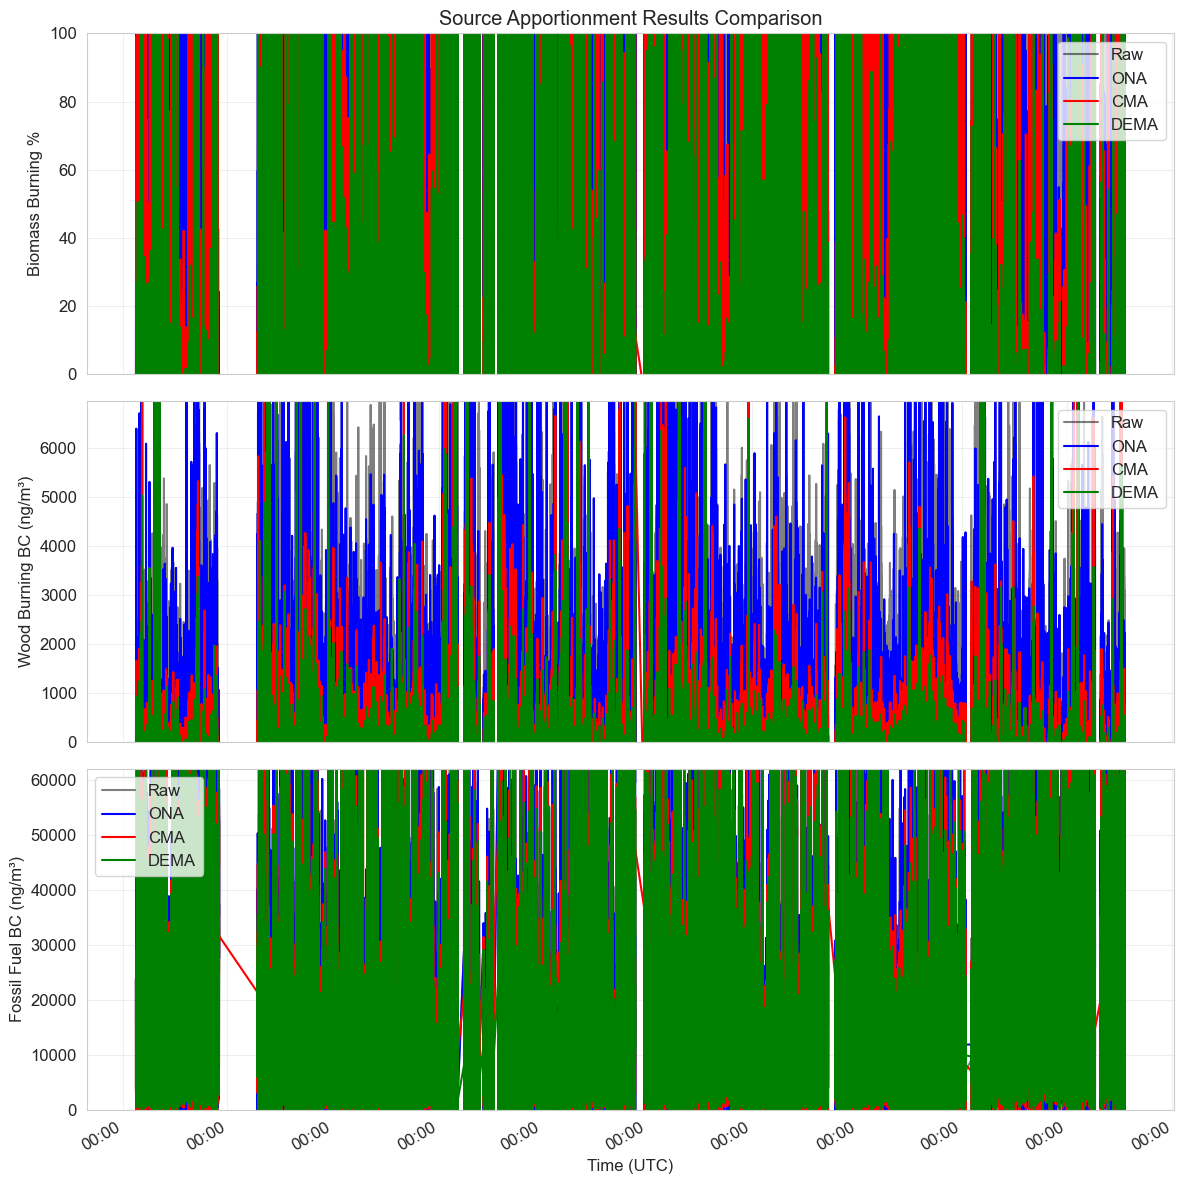


Source Apportionment Statistics:


Method,Component,Mean,Median,Min,Max,Std Dev
str,str,f64,f64,f64,f64,f64
"""Raw""","""BB_Percent""",-26.472931,-33.575272,-1.6076e6,1.2859e6,3375.762898
"""Raw""","""BC_WB""",-2557.283504,-1865.540164,-1.8687e8,1.7249e8,253553.451854
"""Raw""","""BC_FF""",10694.823771,7387.755886,-1.7248e8,1.8688e8,253826.620245
"""ONA""","""BB_Percent""",-27.28955,-32.817456,-1.6076e6,1.2859e6,2648.210467
"""ONA""","""BC_WB""",-2556.955084,-1689.538021,-1.8687e8,1.7249e8,250335.738423
…,…,…,…,…,…,…
"""CMA""","""BC_WB""",-2556.937509,-1780.860643,-6.0683e7,4.9053e7,91729.141711
"""CMA""","""BC_FF""",10693.662145,7313.751088,-4.9049e7,6.0694e7,92394.071205
"""DEMA""","""BB_Percent""",-29.44112,-33.214672,-474158.756644,380956.495224,1113.763338



Zoomed view of first 1000 points:


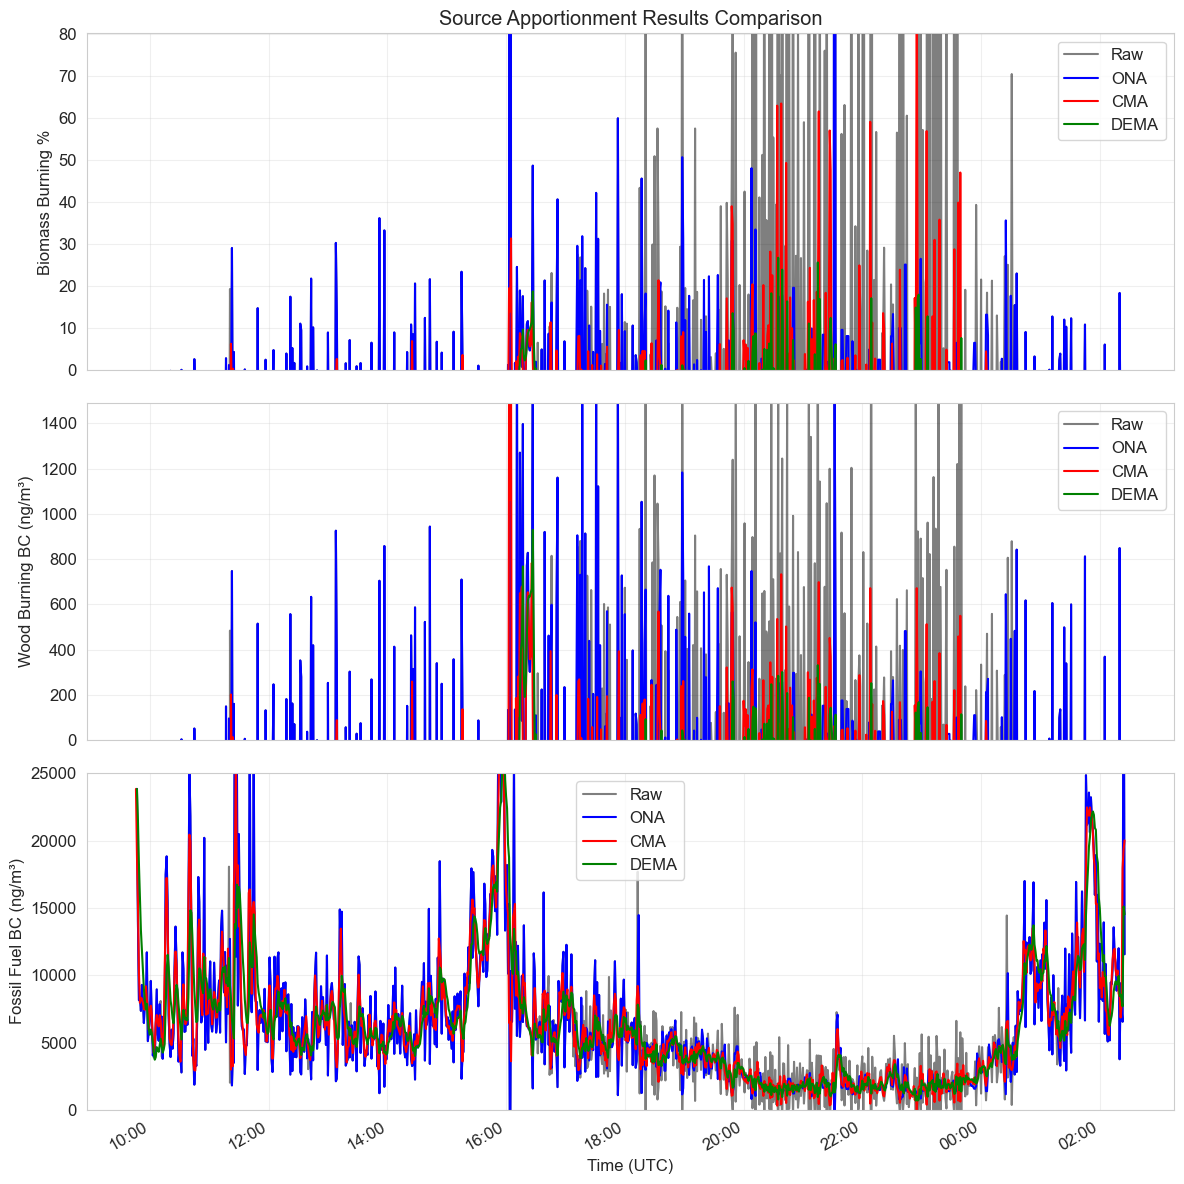


Source Apportionment Statistics:


Method,Component,Mean,Median,Min,Max,Std Dev
str,str,f64,f64,f64,f64,f64
"""Raw""","""BB_Percent""",-42.553042,-17.353741,-37965.639158,3058.269438,1213.215077
"""Raw""","""BC_WB""",-969.336621,-797.725304,-13660.514518,6385.844869,1513.255001
"""Raw""","""BC_FF""",6188.024309,5202.559736,-6015.844869,42273.802649,5136.650233
"""ONA""","""BB_Percent""",-12.613281,-16.623173,-75.396938,1725.904019,59.188806
"""ONA""","""BC_WB""",-969.336621,-636.043762,-13660.514518,6385.844869,1426.095241
…,…,…,…,…,…,…
"""CMA""","""BC_WB""",-973.169939,-755.6409,-6216.885891,1651.950832,1060.967024
"""CMA""","""BC_FF""",6203.047939,5395.912753,5.301043,28998.635083,4418.430563
"""DEMA""","""BB_Percent""",-16.330175,-17.542572,-45.222425,26.756401,9.57253


In [35]:
# Plot comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if bc_col in data.columns:
        print(f"\nPlots for {wavelength} wavelength comparison:")
        
        # Plot full dataset
        plot_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)
        
        # Plot a sample period (first 1000 points or 10% of data, whichever is smaller)
        sample_size = min(1000, int(len(data) * 0.1))
        if sample_size < len(data):
            print(f"\nZoomed view of first {sample_size} points:")
            plot_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength, (0, sample_size))

# Plot source apportionment comparisons
print("\nSource apportionment comparison plots:")
plot_source_apportionment_comparison(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa)

# Plot a sample period
sample_size = min(1000, int(len(data) * 0.1))
if sample_size < len(data):
    print(f"\nZoomed view of first {sample_size} points:")
    plot_source_apportionment_comparison(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa, (0, sample_size))


## 11. Side-by-Side Visualization Comparison
  
Now let's create a side-by-side comparison of all methods for easier visual comparison.

In [36]:
def plot_side_by_side_comparison(data, data_ona, data_cma, data_dema, wavelength='Blue', sample_period=None, timebase=60):
    """
    Plot raw, ONA, CMA, and DEMA processed BC data in a side-by-side grid layout
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    timebase : int
        The timebase in seconds (5, 10, 30, 60, etc.)
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Determine which methods are available
    methods = []
    if bc_col in data.columns:
        methods.append(('Raw', data, bc_col))
    if ona_col in data_ona.columns:
        methods.append(('ONA', data_ona, ona_col))
    if cma_col in data_cma.columns:
        methods.append(('CMA', data_cma, cma_col))
    if dema_col in data_dema.columns:
        methods.append(('DEMA', data_dema, dema_col))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df, col in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas(), col))
    else:
        plot_methods = methods
    
    # Determine number of panels needed (number of methods + 1 for comparison)
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    total_panels = n_methods + 1  # Include comparison panel
    
    # Calculate grid dimensions (approximately square)
    n_rows = int(np.ceil(np.sqrt(total_panels)))
    n_cols = int(np.ceil(total_panels / n_rows))
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharex=True, sharey=True)
    
    # Handle the case of a single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    
    # Flatten for easier indexing
    axes = axes.flatten()
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits
    all_y_values = []
    for name, plot_data, col in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[[col]])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col(col).is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_y_values.append(valid_values.select(pl.col(col)))
    
    if all_y_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_y_values)
        
        # Calculate percentiles
        percentiles = combined_values.select([
            pl.col(combined_values.columns[0]).quantile(0.01).alias("p01"),
            pl.col(combined_values.columns[0]).quantile(0.99).alias("p99")
        ])
        
        ymin = percentiles[0, 0]  # 1st percentile
        ymax = percentiles[0, 1]  # 99th percentile
        
        # Add a small buffer to the y-limits for visual clarity
        y_buffer = (ymax - ymin) * 0.1
        ylim = (ymin - y_buffer, ymax + y_buffer)
    else:
        ylim = (0, 1)  # Default if no valid values
    
    # Plot titles and data for individual methods
    for i, (name, plot_data, col) in enumerate(plot_methods):
        title = f'{name} processed ({timebase}s)'
        if name == 'Raw':
            title = f'Raw data ({timebase}s)'
            axes[i].plot(x, plot_data[col], 'k-', label=name)
        elif name == 'ONA':
            axes[i].plot(x, plot_data[col], 'b-', label=name)
        elif name == 'CMA':
            axes[i].plot(x, plot_data[col], 'r-', label=name)
        elif name == 'DEMA':
            axes[i].plot(x, plot_data[col], 'g-', label=name)
        
        axes[i].set_title(title)
        axes[i].set_ylabel(f'{wavelength} BC (ng/m³)')
        axes[i].set_ylim(ylim)
        axes[i].grid(True, alpha=0.3)
    
    # Use the comparison panel (should be the next one after all individual method panels)
    comp_idx = n_methods  # This should be the index for the comparison panel
    
    # Plot all methods for comparison in the comparison panel
    for name, plot_data, col in plot_methods:
        if name == 'Raw':
            axes[comp_idx].plot(x, plot_data[col], 'k-', alpha=0.5, label=name)
        elif name == 'ONA':
            axes[comp_idx].plot(x, plot_data[col], 'b-', label=name)
        elif name == 'CMA':
            axes[comp_idx].plot(x, plot_data[col], 'r-', label=name)
        elif name == 'DEMA':
            axes[comp_idx].plot(x, plot_data[col], 'g-', label=name)
    
    axes[comp_idx].set_title('All methods comparison')
    axes[comp_idx].set_ylabel(f'{wavelength} BC (ng/m³)')
    axes[comp_idx].set_xlabel(x_label)
    axes[comp_idx].set_ylim(ylim)
    axes[comp_idx].grid(True, alpha=0.3)
    axes[comp_idx].legend()
    
    # Hide any extra subplots
    for i in range(total_panels, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Side-by-Side Comparison of Processing Methods ({wavelength} Wavelength)', y=1.02, fontsize=16)
    
    # Add method information in the figure footer
    plt.figtext(0.5, -0.01, f"Methods: Raw = Original; ONA = Optimized Noise Algorithm; CMA = Centered Moving Average; DEMA = Double Exponential Moving Average", 
                ha='center', fontsize=10, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics about each method
    stats_data = []
    for name, plot_data, col in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[[col]])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.lit(wavelength).alias("Wavelength"),
            pl.col(col).mean().alias("Mean"),
            pl.col(col).median().alias("Median"),
            pl.col(col).min().alias("Min"),
            pl.col(col).max().alias("Max"),
            pl.col(col).std().alias("Std Dev")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None

In [38]:
def plot_source_apportionment_side_by_side(data_raw, data_ona, data_cma, data_dema, sample_period=None, timebase=60):
    """
    Plot source apportionment results in a side-by-side grid layout
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    timebase : int
        The timebase in seconds (5, 10, 30, 60, etc.)
    """
    # Determine which methods have source apportionment data
    methods = []
    if 'BB_Percent' in data_raw.columns:
        methods.append(('Raw', data_raw))
    if 'BB_Percent' in data_ona.columns:
        methods.append(('ONA', data_ona))
    if 'BB_Percent' in data_cma.columns:
        methods.append(('CMA', data_cma))
    if 'BB_Percent' in data_dema.columns:
        methods.append(('DEMA', data_dema))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas()))
    else:
        plot_methods = methods
    
    # Determine number of panels needed (number of methods + 1 for comparison)
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    total_panels = n_methods + 1  # Include comparison panel
    
    # Calculate grid dimensions (approximately square)
    n_rows = int(np.ceil(np.sqrt(total_panels)))
    n_cols = int(np.ceil(total_panels / n_rows))
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharex=True, sharey=True)
    
    # Handle the case of a single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    
    # Flatten for easier indexing
    axes = axes.flatten()
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits for BB percentage
    all_bb_values = []
    for name, plot_data in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col('BB_Percent').is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_bb_values.append(valid_values.select(pl.col('BB_Percent')))
    
    if all_bb_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_bb_values)
        
        # Calculate percentiles with clipping to 0-100 range
        percentiles = combined_values.select([
            pl.max(pl.col('BB_Percent').quantile(0.01), pl.lit(0)).alias("p01"),
            pl.min(pl.col('BB_Percent').quantile(0.99), pl.lit(100)).alias("p99")
        ])
        
        ymin_bb = percentiles[0, 0]  # 1st percentile, but not below 0
        ymax_bb = percentiles[0, 1]  # 99th percentile, but not above 100
        
        # Add a small buffer to the y-limits for visual clarity
        y_buffer_bb = (ymax_bb - ymin_bb) * 0.1
        ylim_bb = (max(0, ymin_bb - y_buffer_bb), min(100, ymax_bb + y_buffer_bb))
    else:
        ylim_bb = (0, 100)  # Default range for BB%
    
    # Plot titles and data for individual methods
    for i, (name, plot_data) in enumerate(plot_methods):
        title = f'{name} processed ({timebase}s)'
        if name == 'Raw':
            title = f'Raw data ({timebase}s)'
            axes[i].plot(x, plot_data['BB_Percent'], 'k-', label=name)
        elif name == 'ONA':
            axes[i].plot(x, plot_data['BB_Percent'], 'b-', label=name)
        elif name == 'CMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'r-', label=name)
        elif name == 'DEMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'g-', label=name)
        
        axes[i].set_title(title)
        axes[i].set_ylabel('Biomass Burning %')
        axes[i].set_ylim(ylim_bb)
        axes[i].grid(True, alpha=0.3)
    
    # Use the comparison panel (should be the next one after all individual method panels)
    comp_idx = n_methods  # This should be the index for the comparison panel
    
    # Plot all methods for comparison in the comparison panel
    for name, plot_data in plot_methods:
        if name == 'Raw':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'k-', alpha=0.5, label=name)
        elif name == 'ONA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'b-', label=name)
        elif name == 'CMA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'r-', label=name)
        elif name == 'DEMA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'g-', label=name)
    
    axes[comp_idx].set_title('All methods comparison')
    axes[comp_idx].set_ylabel('Biomass Burning %')
    axes[comp_idx].set_xlabel(x_label)
    axes[comp_idx].set_ylim(ylim_bb)
    axes[comp_idx].grid(True, alpha=0.3)
    axes[comp_idx].legend()
    
    # Hide any extra subplots
    for i in range(total_panels, len(axes)):
        axes[i].set_visible(False)
    
    if x_label == 'Time (UTC)':
        fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.suptitle('Side-by-Side Comparison of Source Apportionment Results', y=1.02, fontsize=16)
    
    # Add method information in the figure footer
    plt.figtext(0.5, -0.01, 
                "Biomass Burning (BB) % shows the proportion of black carbon from wood/biomass combustion vs. fossil fuels", 
                ha='center', fontsize=10, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics about source apportionment
    stats_data = []
    for name, plot_data in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.col('BB_Percent').mean().alias("Mean BB%"),
            pl.col('BB_Percent').median().alias("Median BB%"),
            pl.col('BB_Percent').min().alias("Min BB%"),
            pl.col('BB_Percent').max().alias("Max BB%"),
            pl.col('BB_Percent').std().alias("Std Dev BB%")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None


Side-by-side comparison for Blue wavelength:


ShapeError: unable to vstack, column names don't match: "Blue BCc" and "Blue_BC_ONA"

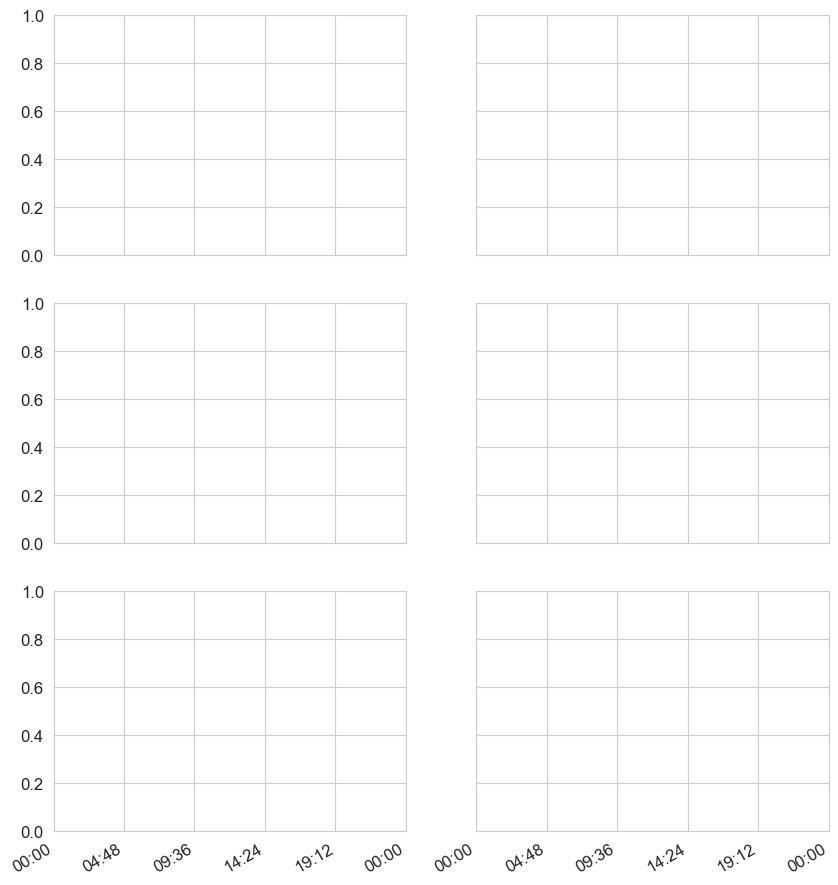

In [39]:
# Determine the timebase from the data using Polars
pl_data = pl.from_pandas(data)
if 'Timebase (s)' in pl_data.columns:
    timebase = pl_data.select(pl.col('Timebase (s)')).row(0)[0]
else:
    timebase = 60  # default assumption

# Plot side-by-side comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    
    if bc_col in pl_data.columns:
        print(f"\nSide-by-side comparison for {wavelength} wavelength:")
        
        # Plot full dataset
        plot_side_by_side_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema,
                                  wavelength, timebase=timebase)
        
        # Calculate sample size using Polars for efficiency
        data_length = pl_data.height
        sample_size = min(1000, int(data_length * 0.1))
        
        if sample_size < data_length:
            print(f"\nZoomed view of first {sample_size} points:")
            plot_side_by_side_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema,
                                      wavelength, (0, sample_size), timebase=timebase)

# Plot source apportionment comparisons
print("\nSide-by-side source apportionment comparison:")
sa_stats = plot_source_apportionment_side_by_side(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
                                     processed_data_dema_sa, timebase=timebase)

# If statistics were returned, display them
if sa_stats is not None:
    print("\nSource Apportionment Statistics:")
    display(sa_stats)

# Plot a sample period for source apportionment using the same sample size for consistency
if sample_size < data_length:
    print(f"\nZoomed view of first {sample_size} points for source apportionment:")
    sa_zoom_stats = plot_source_apportionment_side_by_side(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
                                        processed_data_dema_sa, (0, sample_size), timebase=timebase)
    
    # If zoom statistics were returned, display them
    if sa_zoom_stats is not None:
        print("\nZoomed Source Apportionment Statistics:")
        display(sa_zoom_stats)

## 12. Stacked Temporal Comparison
  
Let's also create a visualization that stacks the temporal plots vertically for each processing method.

In [ ]:
def plot_stacked_temporal_comparison(data, data_ona, data_cma, data_dema, wavelength='Blue', sample_period=None):
    """
    Plot stacked temporal comparison of raw, ONA, CMA, and DEMA processed BC data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Determine which methods are available
    methods = []
    if bc_col in data.columns:
        methods.append(('Raw', data, bc_col))
    if ona_col in data_ona.columns:
        methods.append(('ONA', data_ona, ona_col))
    if cma_col in data_cma.columns:
        methods.append(('CMA', data_cma, cma_col))
    if dema_col in data_dema.columns:
        methods.append(('DEMA', data_dema, dema_col))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df, col in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas(), col))
    else:
        plot_methods = methods
    
    # Determine number of panels needed
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    # Create a figure with vertically stacked subplots
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, n_methods*3), sharex=True)
    if n_methods == 1:
        axes = [axes]  # Make it a list for consistent indexing
    
    # Determine the timebase using Polars for efficiency
    if 'Timebase (s)' in plot_methods[0][1].columns:
        # Convert to Polars for efficient access
        pl_first_data = pl.from_pandas(plot_methods[0][1][['Timebase (s)']])
        timebase = pl_first_data.select(pl.col('Timebase (s)')).row(0)[0]
    else:
        timebase = 60  # default
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits
    all_y_values = []
    for name, plot_data, col in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[[col]])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col(col).is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_y_values.append(valid_values.select(pl.col(col)))
    
    if all_y_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_y_values)
        
        # Calculate percentiles
        percentiles = combined_values.select([
            pl.col(combined_values.columns[0]).quantile(0.01).alias("p01"),
            pl.col(combined_values.columns[0]).quantile(0.99).alias("p99")
        ])
        
        ymin = percentiles[0, 0]  # 1st percentile
        ymax = percentiles[0, 1]  # 99th percentile
        
        # Ensure min and max are different to prevent division by zero
        if ymin == ymax:
            ymin -= 10
            ymax += 10
            
        # Add a small buffer to the y-limits for visual clarity
        y_buffer = (ymax - ymin) * 0.1
        ylim = (ymin - y_buffer, ymax + y_buffer)
    else:
        ylim = (0, 1)  # Default if no valid values
    
    # Plot data for each method
    for i, (name, plot_data, col) in enumerate(plot_methods):
        if name == 'Raw':
            axes[i].plot(x, plot_data[col], 'k-', label=f'Raw ({timebase}s)')
        elif name == 'ONA':
            axes[i].plot(x, plot_data[col], 'b-', label=f'ONA ({timebase}s)')
        elif name == 'CMA':
            axes[i].plot(x, plot_data[col], 'r-', label=f'CMA ({timebase}s)')
        elif name == 'DEMA':
            axes[i].plot(x, plot_data[col], 'g-', label=f'DEMA ({timebase}s)')
        
        axes[i].set_ylabel(f'{wavelength} BC (ng/m³)')
        axes[i].legend(loc='upper right')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(ylim)
    
    axes[-1].set_xlabel(x_label)
    plt.suptitle(f'Stacked Temporal Comparison ({wavelength} Wavelength)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    # Add descriptive text about the methods
    method_descriptions = {
        'Raw': 'Unprocessed data',
        'ONA': 'Optimized Noise-reduction Algorithm (adaptive time-averaging based on ΔATN)',
        'CMA': 'Centered Moving Average (fixed window smoothing)',
        'DEMA': 'Double Exponentially Weighted Moving Average (reduces noise with minimal lag)'
    }
    
    available_method_names = [name for name, _, _ in plot_methods]
    description_text = " | ".join([f"{name}: {method_descriptions[name]}" for name in available_method_names])
    
    plt.figtext(0.5, -0.01, description_text, ha='center', fontsize=9, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics for each method
    stats_data = []
    for name, plot_data, col in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[[col]])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.lit(wavelength).alias("Wavelength"),
            pl.col(col).mean().alias("Mean"),
            pl.col(col).median().alias("Median"),
            pl.col(col).min().alias("Min"),
            pl.col(col).max().alias("Max"),
            pl.col(col).std().alias("Std Dev")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None

In [ ]:
def plot_stacked_source_apportionment(data_raw, data_ona, data_cma, data_dema, sample_period=None):
    """
    Plot stacked temporal comparison of source apportionment results
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Determine which methods have source apportionment data
    methods = []
    if 'BB_Percent' in data_raw.columns:
        methods.append(('Raw', data_raw))
    if 'BB_Percent' in data_ona.columns:
        methods.append(('ONA', data_ona))
    if 'BB_Percent' in data_cma.columns:
        methods.append(('CMA', data_cma))
    if 'BB_Percent' in data_dema.columns:
        methods.append(('DEMA', data_dema))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas()))
    else:
        plot_methods = methods
    
    # Determine number of panels needed
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    # Create a figure with vertically stacked subplots
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, n_methods*3), sharex=True)
    if n_methods == 1:
        axes = [axes]  # Make it a list for consistent indexing
    
    # Determine the timebase using Polars for efficiency
    if 'Timebase (s)' in plot_methods[0][1].columns:
        # Convert to Polars for efficient access
        pl_first_data = pl.from_pandas(plot_methods[0][1][['Timebase (s)']])
        timebase = pl_first_data.select(pl.col('Timebase (s)')).row(0)[0]
    else:
        timebase = 60  # default
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits for BB percentage
    all_bb_values = []
    for name, plot_data in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col('BB_Percent').is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_bb_values.append(valid_values.select(pl.col('BB_Percent')))
    
    if all_bb_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_bb_values)
        
        # Calculate percentiles with clipping to 0-100 range
        percentiles = combined_values.select([
            pl.max(pl.col('BB_Percent').quantile(0.01), pl.lit(0)).alias("p01"),
            pl.min(pl.col('BB_Percent').quantile(0.99), pl.lit(100)).alias("p99")
        ])
        
        ymin = percentiles[0, 0]  # 1st percentile, but not below 0
        ymax = percentiles[0, 1]  # 99th percentile, but not above 100
        
        # Ensure min and max are different to prevent division by zero
        if ymin == ymax:
            if ymin == 0:
                ymax = 10  # If all zeros, set max to 10%
            elif ymax == 100:
                ymin = 90  # If all 100s, set min to 90%
            else:
                # Otherwise add/subtract 5 percentage points
                ymin = max(0, ymin - 5)
                ymax = min(100, ymax + 5)
            
        # Add a small buffer to the y-limits for visual clarity
        y_buffer = (ymax - ymin) * 0.1
        ylim = (max(0, ymin - y_buffer), min(100, ymax + y_buffer))
    else:
        ylim = (0, 100)  # Default range for BB%
    
    # Plot data for each method
    for i, (name, plot_data) in enumerate(plot_methods):
        if name == 'Raw':
            axes[i].plot(x, plot_data['BB_Percent'], 'k-', label=f'Raw ({timebase}s)')
        elif name == 'ONA':
            axes[i].plot(x, plot_data['BB_Percent'], 'b-', label=f'ONA ({timebase}s)')
        elif name == 'CMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'r-', label=f'CMA ({timebase}s)')
        elif name == 'DEMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'g-', label=f'DEMA ({timebase}s)')
        
        axes[i].set_ylabel('Biomass Burning %')
        axes[i].legend(loc='upper right')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(ylim)
    
    axes[-1].set_xlabel(x_label)
    plt.suptitle('Stacked Temporal Comparison of Source Apportionment Results', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    # Add information about source apportionment in the figure footer
    plt.figtext(0.5, -0.01, 
                "Biomass Burning (BB) % shows the estimated proportion of black carbon from wood/biomass burning versus fossil fuel combustion", 
                ha='center', fontsize=9, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics about source apportionment
    stats_data = []
    for name, plot_data in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.col('BB_Percent').mean().alias("Mean BB%"),
            pl.col('BB_Percent').median().alias("Median BB%"),
            pl.col('BB_Percent').min().alias("Min BB%"),
            pl.col('BB_Percent').max().alias("Max BB%"),
            pl.col('BB_Percent').std().alias("Std Dev BB%")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None


Stacked temporal comparison for Blue wavelength:


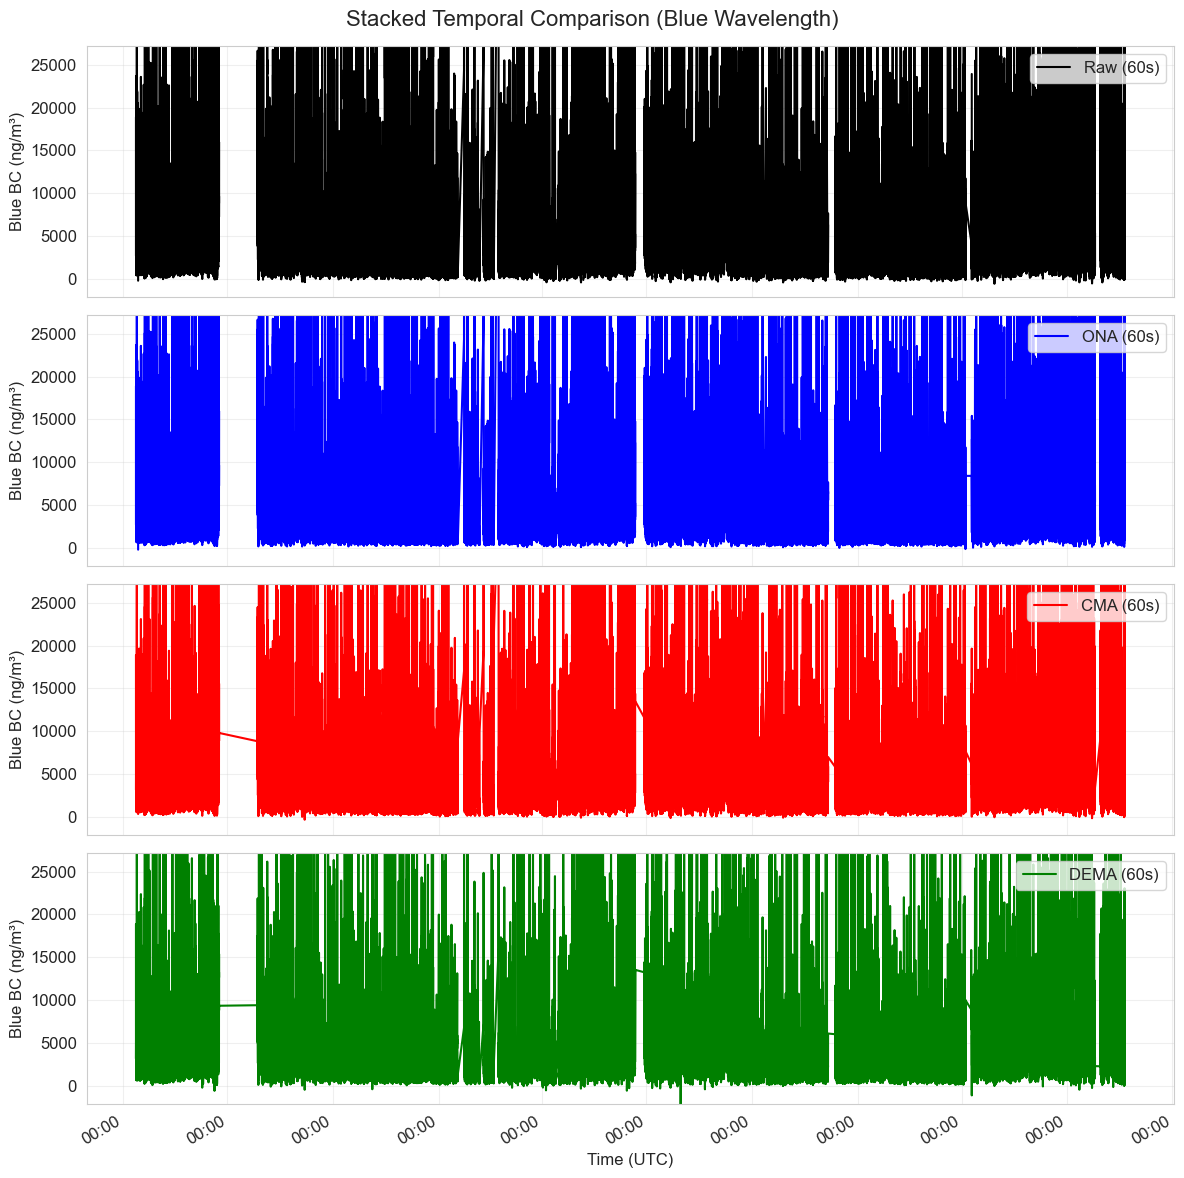


Zoomed view of first 1000 points:


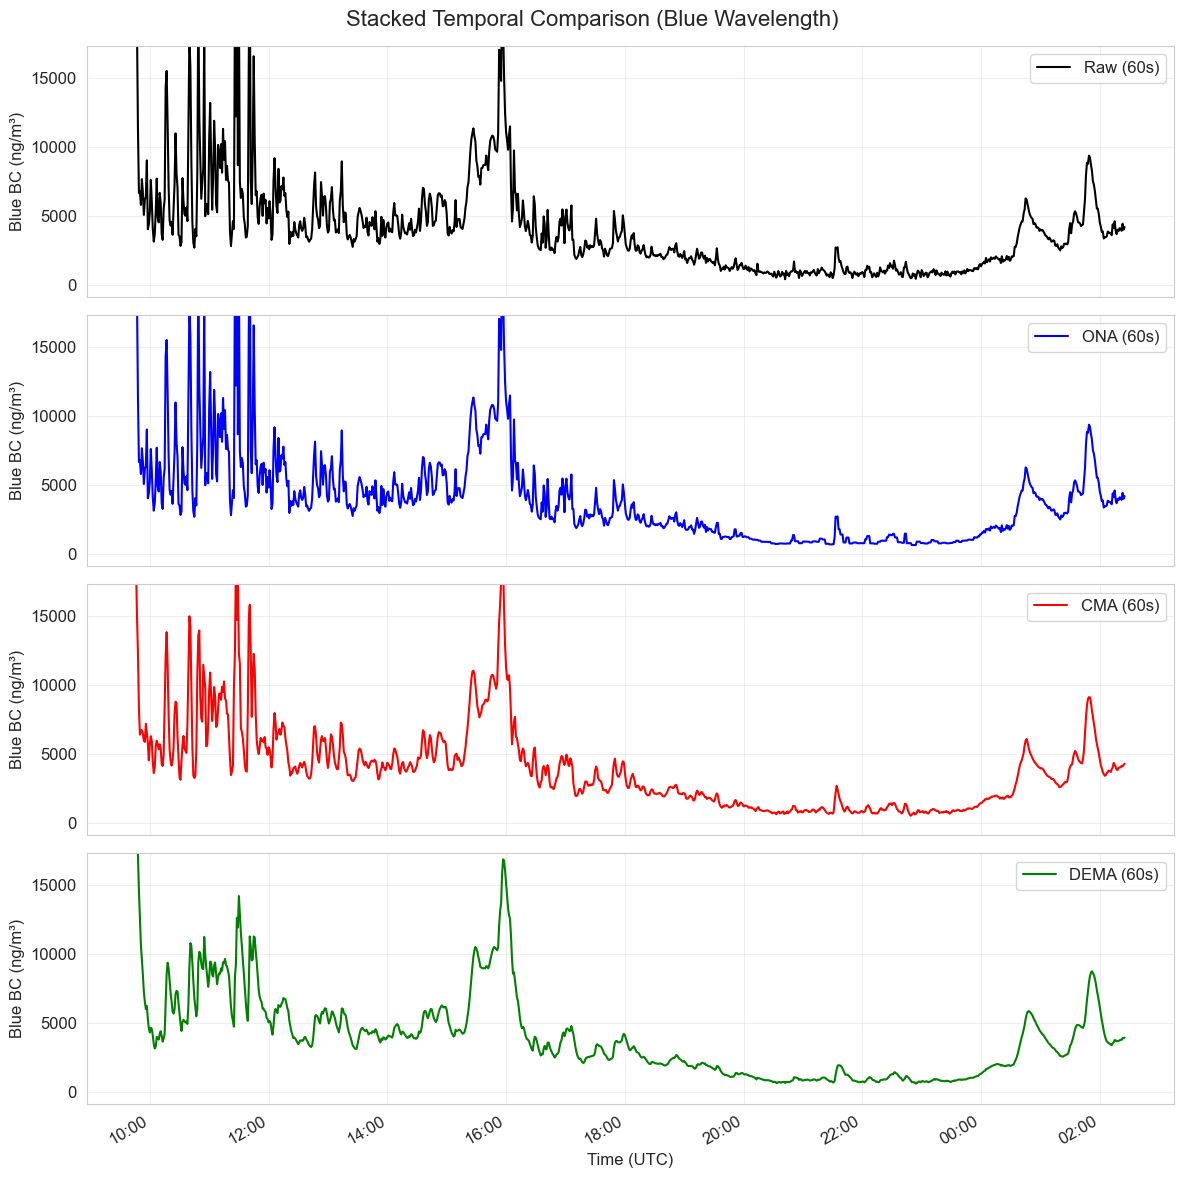


Stacked temporal comparison for IR wavelength:


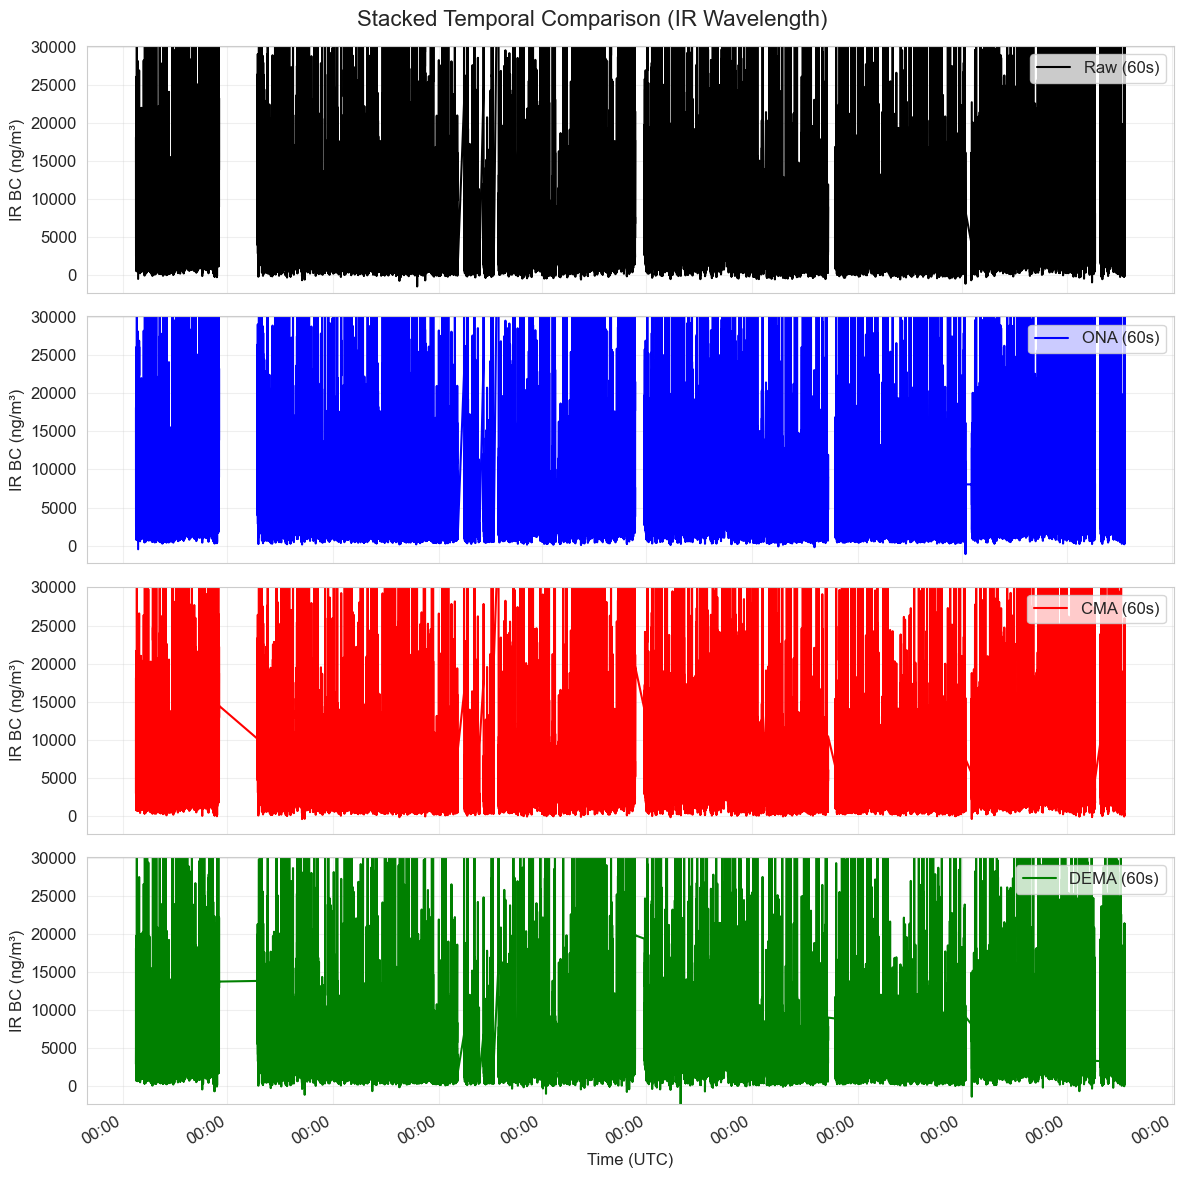


Zoomed view of first 1000 points:


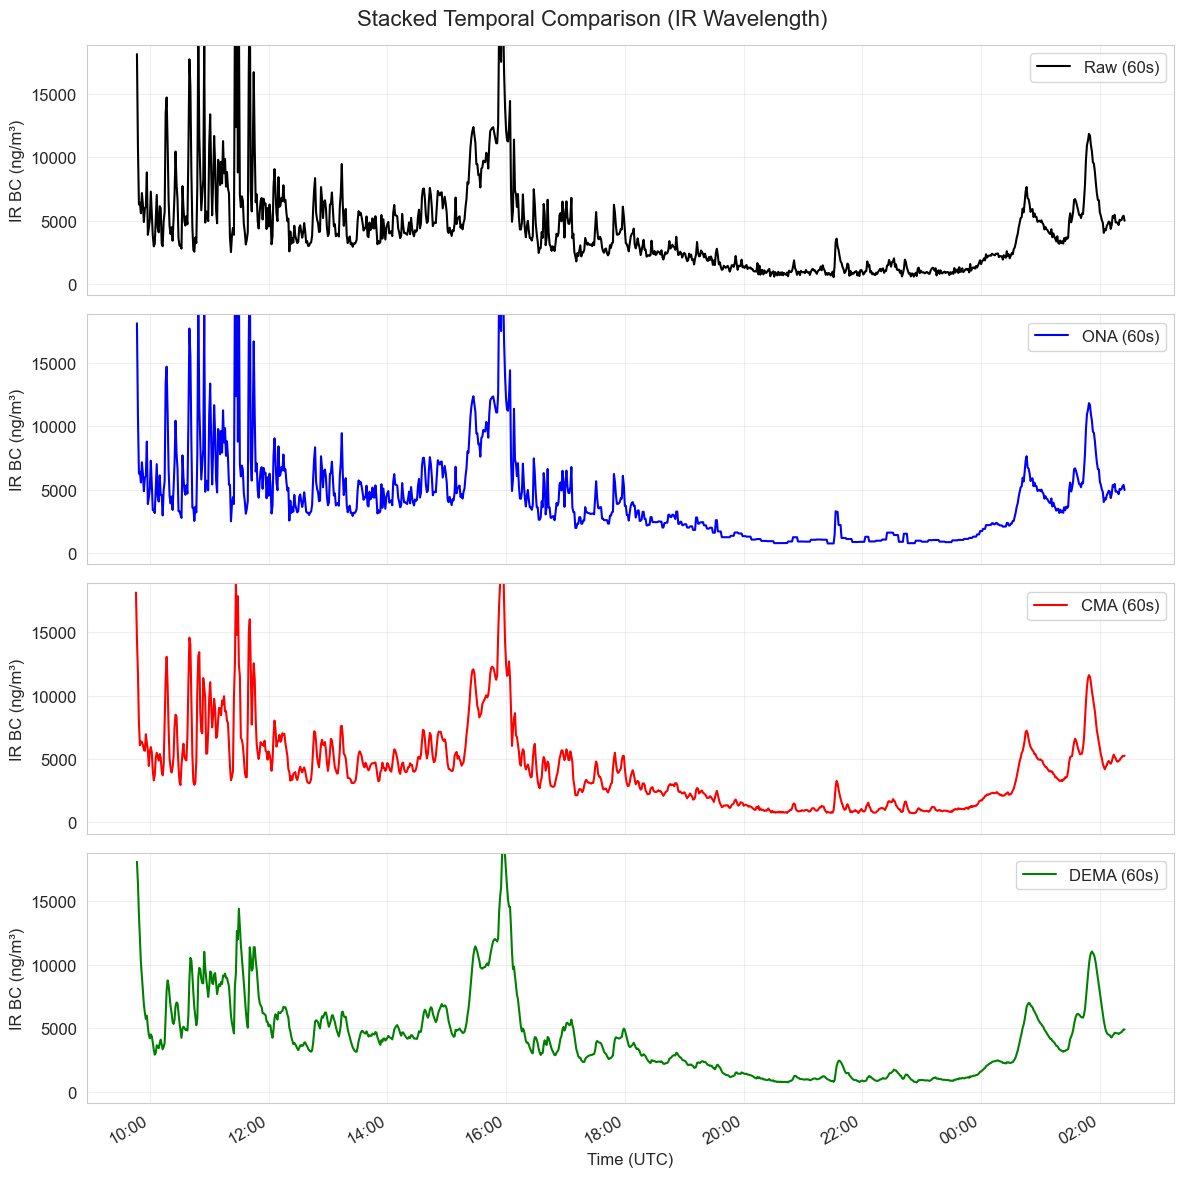


Stacked source apportionment comparison:


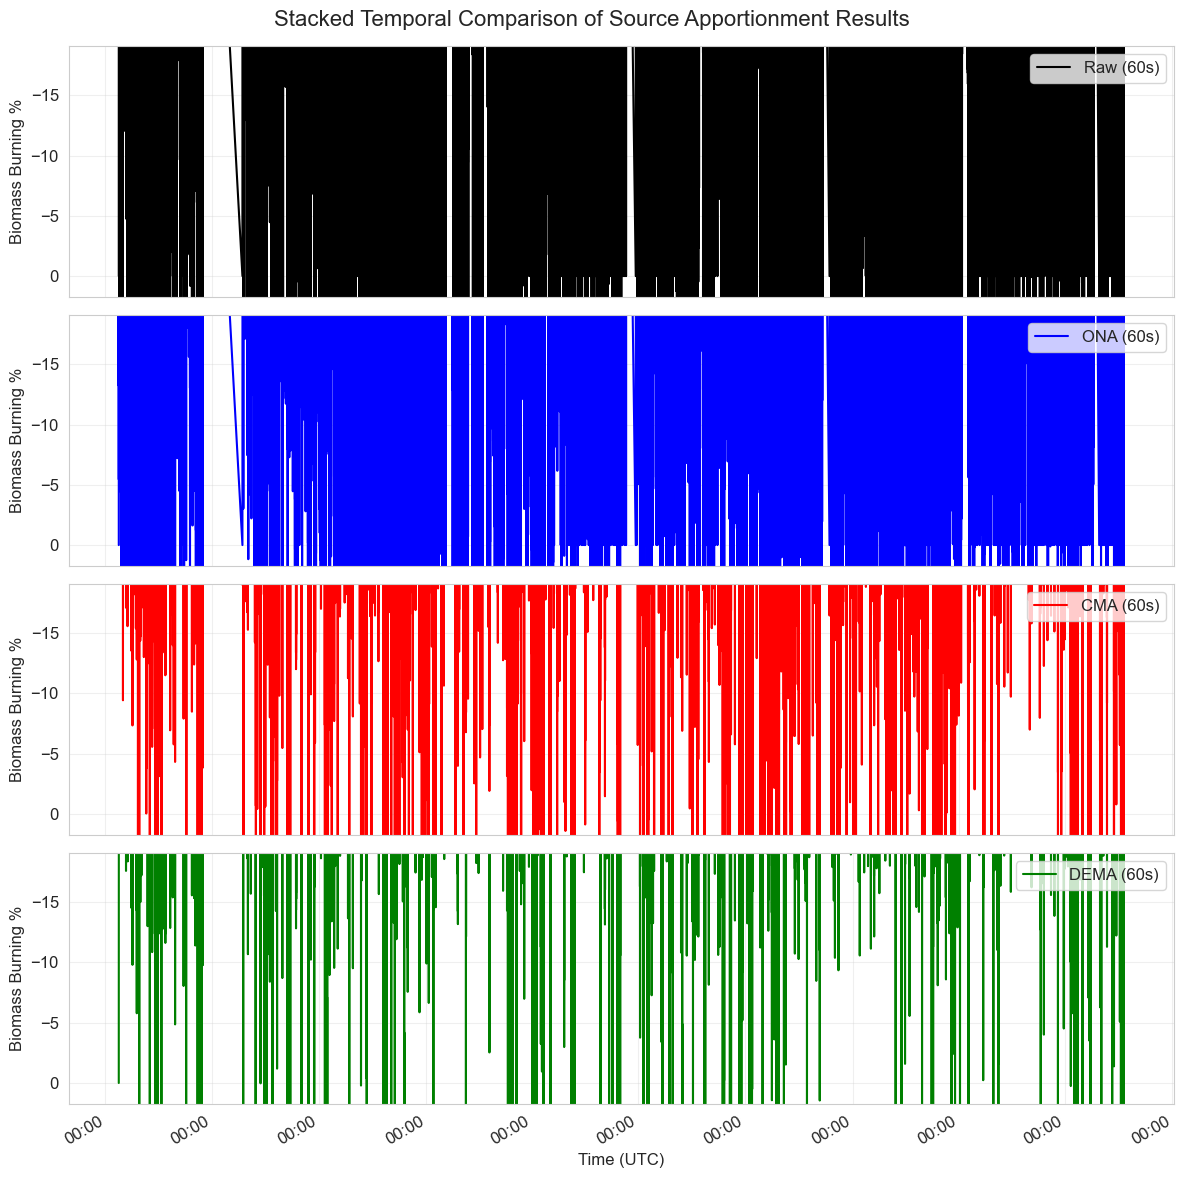


Zoomed view of first 1000 points for source apportionment:


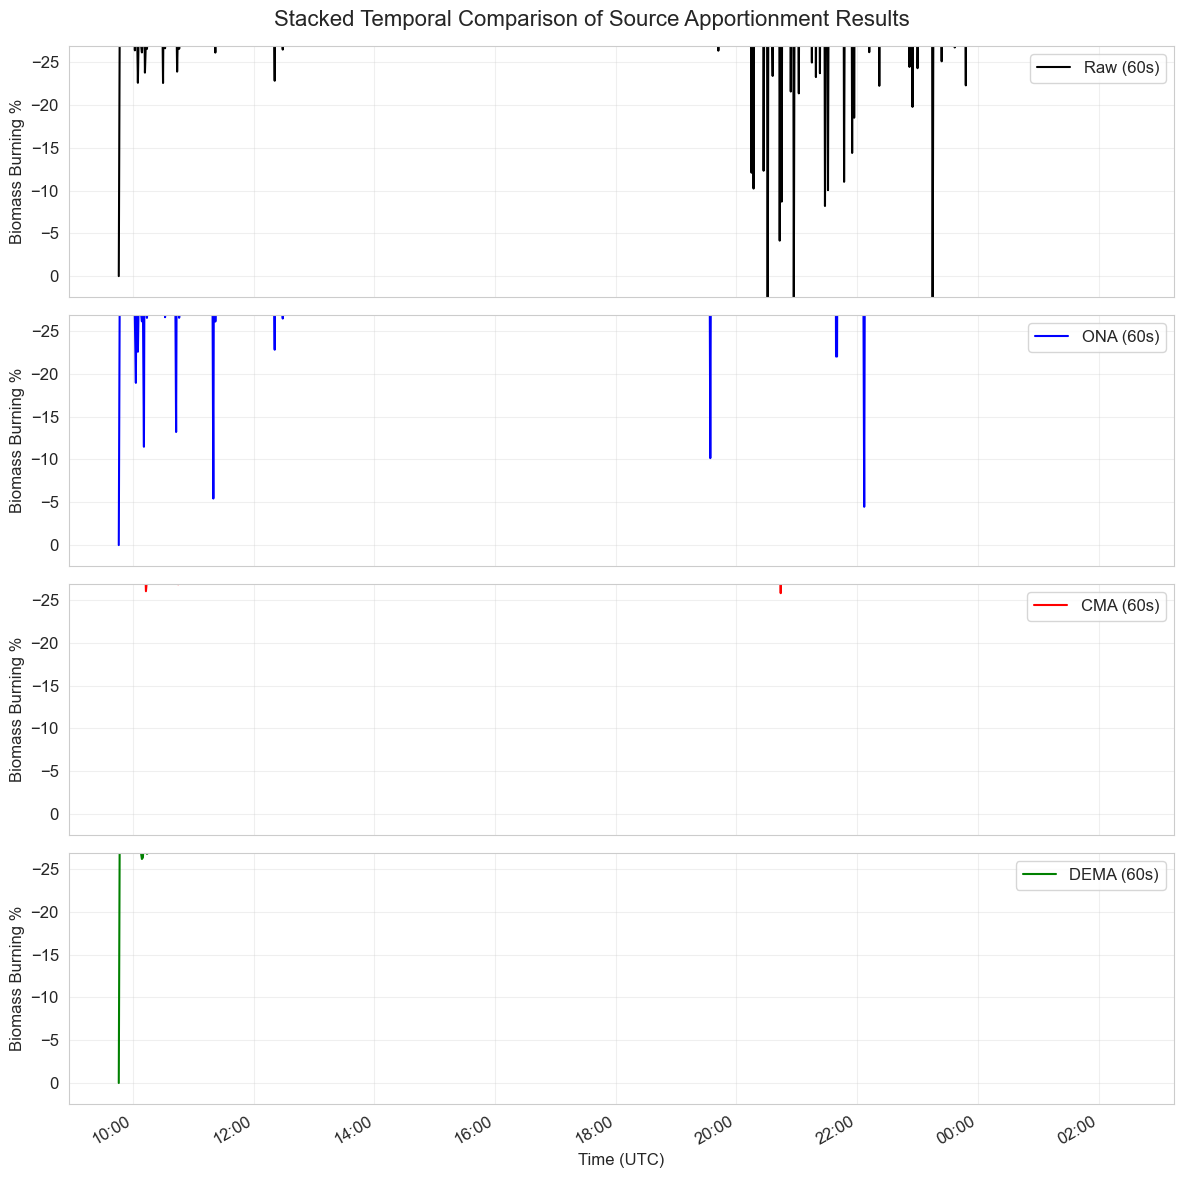

In [ ]:
# Plot stacked temporal comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Use Polars to check if required columns exist
    pl_data = pl.from_pandas(data)
    pl_ona = pl.from_pandas(processed_data_ona)
    pl_cma = pl.from_pandas(processed_data_cma)
    pl_dema = pl.from_pandas(processed_data_dema)
    
    methods_available = []
    if bc_col in pl_data.columns:
        methods_available.append('Raw')
    if ona_col in pl_ona.columns:
        methods_available.append('ONA')
    if cma_col in pl_cma.columns:
        methods_available.append('CMA')
    if dema_col in pl_dema.columns:
        methods_available.append('DEMA')
    
    # Only proceed if at least two methods are available
    if len(methods_available) >= 2:
        print(f"\nStacked temporal comparison for {wavelength} wavelength:")
        
        # Plot full dataset
        tc_stats = plot_stacked_temporal_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)
        
        # Display statistics if returned
        if tc_stats is not None:
            print(f"\nStatistics for {wavelength} wavelength:")
            display(tc_stats)
        
        # Calculate sample size using Polars for efficiency
        data_length = pl_data.height
        sample_size = min(1000, int(data_length * 0.1))
        
        if sample_size < data_length:
            print(f"\nZoomed view of first {sample_size} points:")
            tc_zoom_stats = plot_stacked_temporal_comparison(
                data, processed_data_ona, processed_data_cma, processed_data_dema, 
                wavelength, (0, sample_size)
            )
            
            # Display zoom statistics if returned
            if tc_zoom_stats is not None:
                print(f"\nZoomed Statistics for {wavelength} wavelength:")
                display(tc_zoom_stats)

# Plot stacked source apportionment comparisons
# Use Polars to check if source apportionment data is available for at least two methods
pl_raw_sa = pl.from_pandas(processed_data_raw_sa)
pl_ona_sa = pl.from_pandas(processed_data_ona_sa)
pl_cma_sa = pl.from_pandas(processed_data_cma_sa)
pl_dema_sa = pl.from_pandas(processed_data_dema_sa)

sa_methods_available = []
if 'BB_Percent' in pl_raw_sa.columns:
    sa_methods_available.append('Raw')
if 'BB_Percent' in pl_ona_sa.columns:
    sa_methods_available.append('ONA')
if 'BB_Percent' in pl_cma_sa.columns:
    sa_methods_available.append('CMA')
if 'BB_Percent' in pl_dema_sa.columns:
    sa_methods_available.append('DEMA')

if len(sa_methods_available) >= 2:
    print("\nStacked source apportionment comparison:")
    
    # Plot full source apportionment dataset
    sa_stats = plot_stacked_source_apportionment(
        processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa
    )
    
    # Display statistics if returned
    if sa_stats is not None:
        print("\nSource Apportionment Statistics:")
        display(sa_stats)

    # Calculate sample size using Polars for efficiency
    # Reuse data_length from previous calculation
    if 'data_length' not in locals():
        pl_data = pl.from_pandas(data)
        data_length = pl_data.height
        
    sample_size = min(1000, int(data_length * 0.1))
    
    if sample_size < data_length:
        print(f"\nZoomed view of first {sample_size} points for source apportionment:")
        
        # Plot zoomed source apportionment
        sa_zoom_stats = plot_stacked_source_apportionment(
            processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
            processed_data_dema_sa, (0, sample_size)
        )
        
        # Display zoom statistics if returned
        if sa_zoom_stats is not None:
            print("\nZoomed Source Apportionment Statistics:")
            display(sa_zoom_stats)

## 13. Time Averaging Analysis
 
Let's analyze the time averaging behavior of the ONA method and compare it to the effective averaging window of the CMA and DEMA methods.

In [ ]:
def analyze_time_averaging(data_ona, data_cma, data_dema, wavelength='Blue'):
    """
    Analyze and compare the time averaging behavior of each method
    
    Parameters:
    -----------
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to analyze
    """
    # Check which methods are available
    methods = []
    
    # For ONA, check if points_averaged column exists
    points_averaged_col = f"{wavelength}_points_averaged"
    if points_averaged_col in data_ona.columns:
        # Use Polars for summary statistics
        ona_pl = pl.from_pandas(data_ona[[points_averaged_col]])
        ona_stats = ona_pl.select([
            pl.col(points_averaged_col).mean().alias("mean"),
            pl.col(points_averaged_col).median().alias("median"),
            pl.col(points_averaged_col).min().alias("min"),
            pl.col(points_averaged_col).max().alias("max"),
            pl.col(points_averaged_col).std().alias("std")
        ]).to_dicts()[0]
        
        # For the histogram, we need to convert back to Pandas
        methods.append(('ONA', data_ona[points_averaged_col], ona_stats))
    
    # For CMA, we know the window size
    if f"{wavelength}_BC_CMA" in data_cma.columns:
        # Get the fixed window size for CMA
        if 'Timebase (s)' in data_cma.columns:
            timebase = data_cma['Timebase (s)'].iloc[0]
            if timebase == 1:
                cma_window = 11  # 11 seconds for 1-second data
            elif timebase == 5:
                cma_window = 5   # 25 seconds for 5-second data
            elif timebase == 60:
                cma_window = 3   # 3 minutes for 1-minute data
            else:
                cma_window = 5   # Default for other timebases
        else:
            cma_window = 5       # Default if timebase is unknown
        
        # Make sure window_size is odd
        if cma_window % 2 == 0:
            cma_window += 1
            
        # Create a fixed window size Series with Polars
        cma_points = pl.Series(values=[cma_window] * len(data_cma))
        cma_stats = {"mean": cma_window, "median": cma_window, "min": cma_window, "max": cma_window, "std": 0}
        
        # Convert to Pandas for the plotting
        methods.append(('CMA', pd.Series([cma_window] * len(data_cma)), cma_stats))
    
    # For DEMA, calculate the equivalent window size based on alpha
    if f"{wavelength}_BC_DEMA" in data_dema.columns:
        # Calculate equivalent window size from alpha
        # For DEMA with alpha, N = 2/alpha - 1
        if 'Timebase (s)' in data_dema.columns:
            timebase = data_dema['Timebase (s)'].iloc[0]
            
            # Default alphas based on timebase
            if timebase == 1:
                alpha = 2 / (300 / timebase + 1)  # ~5-minute window for 1-second data
            elif timebase == 5:
                alpha = 2 / (300 / timebase + 1)  # ~5-minute window for 5-second data
            elif timebase == 60:
                alpha = 2 / (900 / timebase + 1)  # ~15-minute window for 60-second data
            else:
                alpha = 0.125  # Default
            
            # Equivalent window size for DEMA
            dema_equiv_window = int(2/alpha - 1)
            dema_points = pl.Series(values=[dema_equiv_window] * len(data_dema))
            dema_stats = {"mean": dema_equiv_window, "median": dema_equiv_window, 
                          "min": dema_equiv_window, "max": dema_equiv_window, "std": 0}
            
            # Convert to Pandas for plotting
            methods.append(('DEMA', pd.Series([dema_equiv_window] * len(data_dema)), dema_stats))
    
    if len(methods) == 0:
        print("No time averaging data available for analysis")
        return
    
    # Create a figure for histogram (using pandas/matplotlib)
    plt.figure(figsize=(12, 6))
    
    # Plot histograms for each method on the same plot
    for name, points, stats in methods:
        if name == 'ONA':
            plt.hist(points, bins=30, alpha=0.7, label=f'ONA (adaptive, mean={stats["mean"]:.1f})')
        elif name == 'CMA':
            plt.hist(points, bins=30, alpha=0.7, label=f'CMA (fixed, window={int(stats["mean"])})')
        elif name == 'DEMA':
            plt.hist(points, bins=30, alpha=0.7, label=f'DEMA (equiv. window={int(stats["mean"])})')
    
    plt.xlabel('Number of Points Averaged')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Averaging Window Size - {wavelength} Wavelength')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a table with summary statistics using Polars
    summary_stats = pl.DataFrame([
        pl.Series(name="Method", values=[name for name, _, _ in methods]),
        pl.Series(name="Mean", values=[stats["mean"] for _, _, stats in methods]),
        pl.Series(name="Median", values=[stats["median"] for _, _, stats in methods]),
        pl.Series(name="Min", values=[stats["min"] for _, _, stats in methods]),
        pl.Series(name="Max", values=[stats["max"] for _, _, stats in methods]),
        pl.Series(name="Std Dev", values=[stats["std"] for _, _, stats in methods])
    ]).transpose()
    
    print(f"\nSummary statistics of window sizes for {wavelength} wavelength:")
    display(summary_stats)
    
    # If ONA is available, plot ECDF
    ona_points = None
    for name, points, _ in methods:
        if name == 'ONA':
            ona_points = points
            break
    
    if ona_points is not None:
        plt.figure(figsize=(10, 6))
        
        # Calculate ECDF
        sorted_points = np.sort(ona_points)
        y = np.arange(1, len(sorted_points) + 1) / len(sorted_points)
        
        # Plot ECDF
        plt.semilogx(sorted_points, y)
        plt.xlabel('Number of Points Averaged')
        plt.ylabel('Fraction of Time Series ≤ Points')
        plt.title(f'ECDF of ONA Adaptive Window Size - {wavelength} Wavelength')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


Time averaging analysis for Blue wavelength:


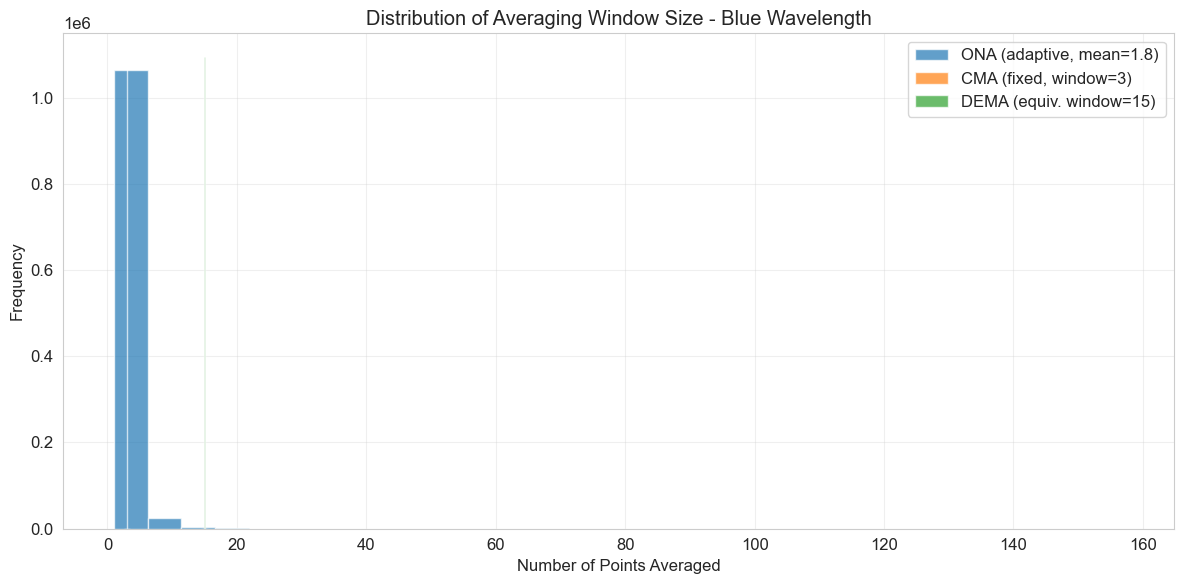


Summary statistics of window sizes for Blue wavelength:


,Mean,Median,Min,Max,Std Dev
ONA,1.82386,1.0,1,157,2.689229
CMA,3.00000,3.0,3,3,0.000000
DEMA,15.00000,15.0,15,15,0.000000


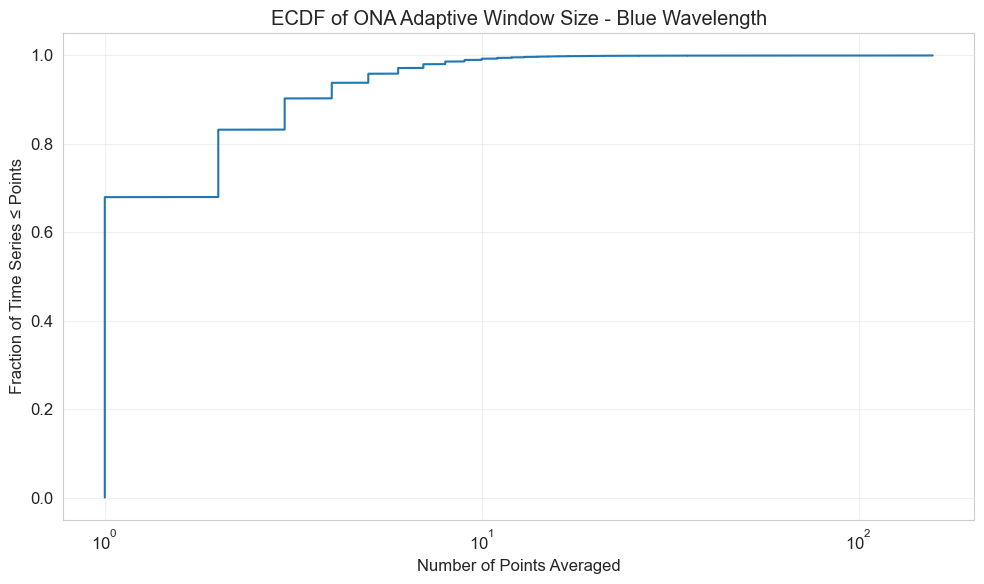


Time averaging analysis for IR wavelength:


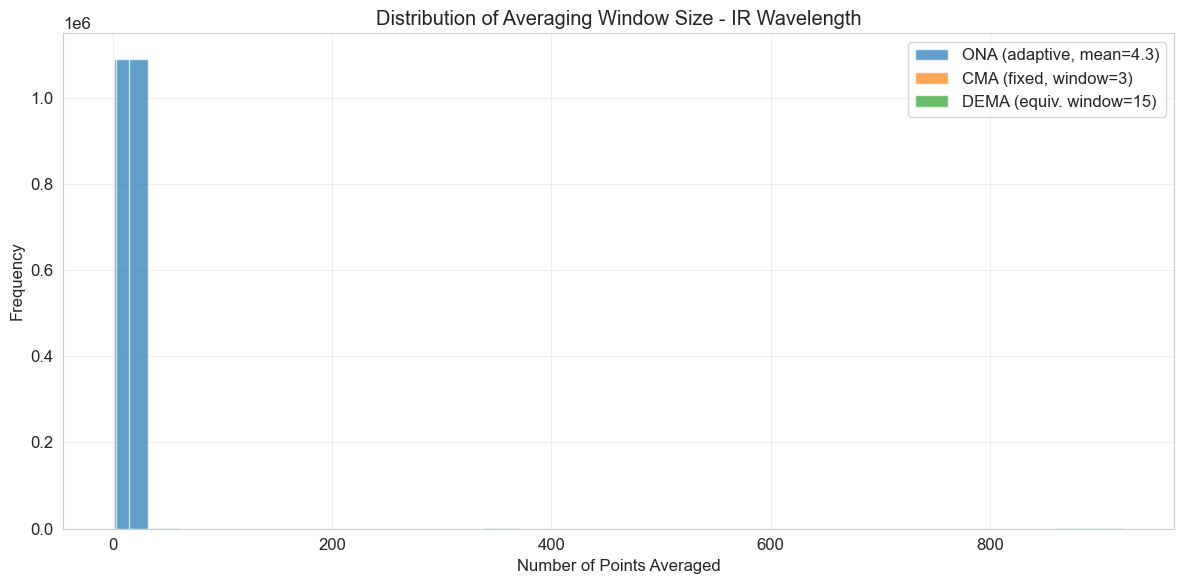


Summary statistics of window sizes for IR wavelength:


,Mean,Median,Min,Max,Std Dev
ONA,4.278042,2.0,1,922,37.265187
CMA,3.000000,3.0,3,3,0.000000
DEMA,15.000000,15.0,15,15,0.000000


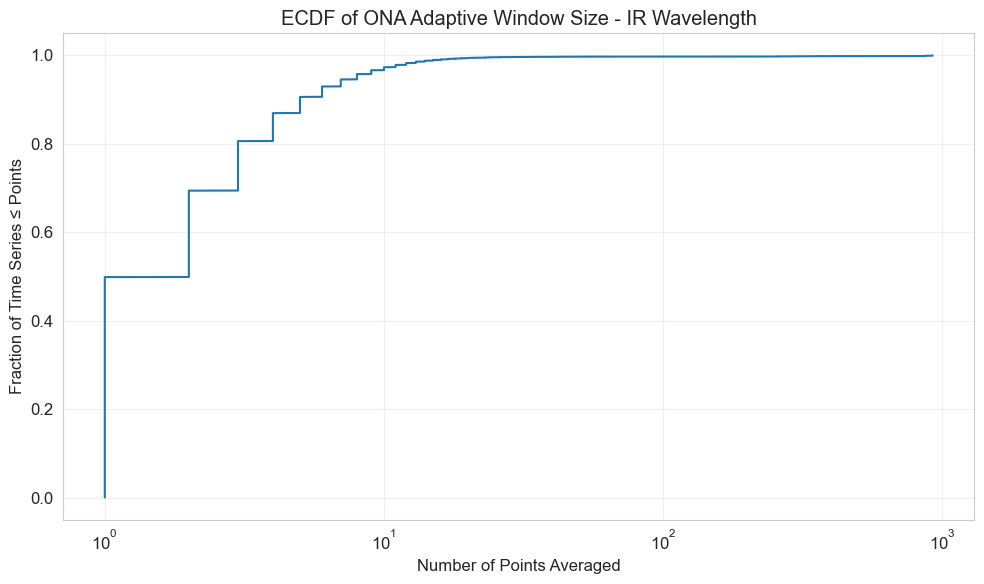

In [40]:
# Analyze time averaging for each wavelength
for wavelength in ['Blue', 'IR']:
    print(f"\nTime averaging analysis for {wavelength} wavelength:")
    analyze_time_averaging(processed_data_ona, processed_data_cma, processed_data_dema, wavelength)


## 14. Comparing Signal Preservation

Let's examine how well each method preserves important signal features by looking at cross-correlation and lag.

In [ ]:
def analyze_signal_preservation(data_raw, data_ona, data_cma, data_dema, wavelength='Blue'):
    """
    Analyze how well each method preserves important signal features
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to analyze
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Check which methods are available
    methods = []
    if bc_col in data_raw.columns:
        # Convert to Polars for standardization
        pl_raw = pl.from_pandas(data_raw[[bc_col]])
        raw_mean = pl_raw.select(pl.col(bc_col).mean())[0, 0]
        raw_std = pl_raw.select(pl.col(bc_col).std())[0, 0]
        
        # Standardize the raw data using Polars
        pl_raw_std = pl_raw.with_columns(
            ((pl.col(bc_col) - raw_mean) / raw_std).alias("std_value")
        )
        
        # Convert back to numpy for correlation calculation
        raw_std_values = pl_raw_std["std_value"].fill_null(0).to_numpy()
        
        # Process each method
        if ona_col in data_ona.columns:
            pl_ona = pl.from_pandas(data_ona[[ona_col]])
            ona_mean = pl_ona.select(pl.col(ona_col).mean())[0, 0]
            ona_std = pl_ona.select(pl.col(ona_col).std())[0, 0]
            
            pl_ona_std = pl_ona.with_columns(
                ((pl.col(ona_col) - ona_mean) / ona_std).alias("std_value")
            )
            
            ona_std_values = pl_ona_std["std_value"].fill_null(0).to_numpy()
            methods.append(('ONA', ona_std_values))
            
        if cma_col in data_cma.columns:
            pl_cma = pl.from_pandas(data_cma[[cma_col]])
            cma_mean = pl_cma.select(pl.col(cma_col).mean())[0, 0]
            cma_std = pl_cma.select(pl.col(cma_col).std())[0, 0]
            
            pl_cma_std = pl_cma.with_columns(
                ((pl.col(cma_col) - cma_mean) / cma_std).alias("std_value")
            )
            
            cma_std_values = pl_cma_std["std_value"].fill_null(0).to_numpy()
            methods.append(('CMA', cma_std_values))
            
        if dema_col in data_dema.columns:
            pl_dema = pl.from_pandas(data_dema[[dema_col]])
            dema_mean = pl_dema.select(pl.col(dema_col).mean())[0, 0]
            dema_std = pl_dema.select(pl.col(dema_col).std())[0, 0]
            
            pl_dema_std = pl_dema.with_columns(
                ((pl.col(dema_col) - dema_mean) / dema_std).alias("std_value")
            )
            
            dema_std_values = pl_dema_std["std_value"].fill_null(0).to_numpy()
            methods.append(('DEMA', dema_std_values))
    else:
        print(f"Raw data for {wavelength} wavelength not available")
        return
    
    if len(methods) == 0:
        print("No processed data available for analysis")
        return
    
    # Calculate cross-correlation and find peak for each method
    results = {}
    lags = {}
    peak_corrs = {}
    
    max_lag = 20  # Maximum lag to consider (in data points)
    
    for name, processed_std in methods:
        # Calculate cross-correlation
        xcorr = np.correlate(raw_std_values, processed_std, mode='full')
        
        # Calculate the midpoint
        mid = len(xcorr) // 2
        
        # Extract the central portion of the cross-correlation
        lag_range = max_lag * 2 + 1
        central_xcorr = xcorr[mid - max_lag:mid + max_lag + 1]
        lags_array = np.arange(-max_lag, max_lag + 1)
        
        # Find the peak correlation and its lag
        peak_idx = np.argmax(central_xcorr)
        peak_lag = lags_array[peak_idx]
        peak_corr = central_xcorr[peak_idx]
        
        # Store results
        results[name] = {
            'xcorr': central_xcorr,
            'lags': lags_array
        }
        lags[name] = peak_lag
        peak_corrs[name] = peak_corr
    
    # Plot cross-correlation for each method
    plt.figure(figsize=(10, 6))
    
    for name, result in results.items():
        if name == 'ONA':
            plt.plot(result['lags'], result['xcorr'], 'b-', label=f'ONA (lag={lags[name]})')
        elif name == 'CMA':
            plt.plot(result['lags'], result['xcorr'], 'r-', label=f'CMA (lag={lags[name]})')
        elif name == 'DEMA':
            plt.plot(result['lags'], result['xcorr'], 'g-', label=f'DEMA (lag={lags[name]})')
    
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Lag (data points)')
    plt.ylabel('Cross-Correlation')
    plt.title(f'Cross-Correlation with Raw Data - {wavelength} Wavelength')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display results in a table using Polars
    summary = pl.DataFrame({
        'Method': list(results.keys()),
        'Lag (data points)': [lags[name] for name in results.keys()],
        'Peak Correlation': [peak_corrs[name] for name in results.keys()]
    })
    
    print(f"\nSignal preservation metrics for {wavelength} wavelength:")
    display(summary)


Signal preservation analysis for Blue wavelength:


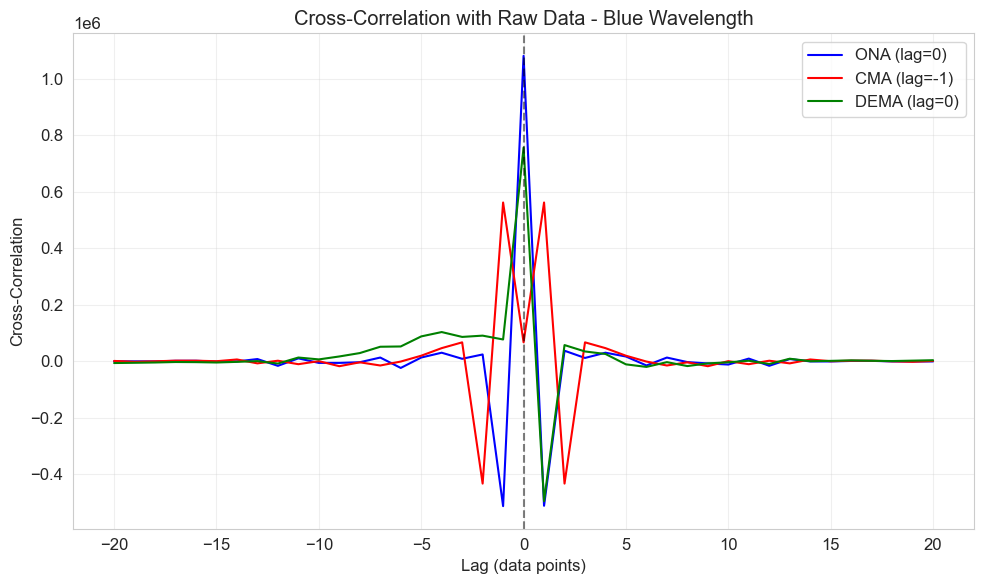


Signal preservation metrics for Blue wavelength:


,Lag (data points),Peak Correlation
ONA,0,1.081024e+06
CMA,-1,5.619668e+05
DEMA,0,7.561537e+05



Signal preservation analysis for IR wavelength:


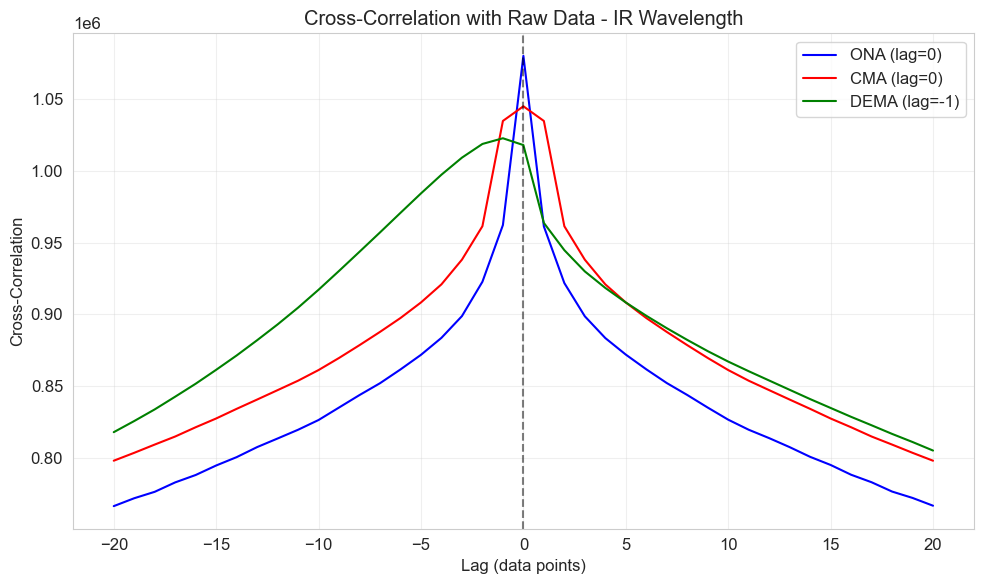


Signal preservation metrics for IR wavelength:


,Lag (data points),Peak Correlation
ONA,0,1.079931e+06
CMA,0,1.044832e+06
DEMA,-1,1.022580e+06


In [42]:
# Analyze signal preservation for each wavelength
for wavelength in ['Blue', 'IR']:
    print(f"\nSignal preservation analysis for {wavelength} wavelength:")
    analyze_signal_preservation(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)


## 15. Comparative Analysis Summary
 
Now let's summarize the performance of all three methods across key metrics.

In [ ]:
def create_method_comparison_table(summary_table):
    """
    Create a comprehensive comparison table for all three methods
    
    Parameters:
    -----------
    summary_table : pandas.DataFrame
        Summary table with metrics from previous analyses
        
    Returns:
    --------
    comparison_df : polars.DataFrame
        Comprehensive comparison of all methods
    """
    # Gather all metrics for comparison
    comparison = {
        'Metric': [
            'Negative Value Reduction', 
            'Noise Reduction Factor', 
            'Correlation with Raw Data',
            'Signal Preservation (Lag)',
            'Time Averaging Behavior',
            'Source Apportionment Stability',
            'Computational Complexity'
        ]
    }
    
    # Add columns for each method
    methods = ['ONA', 'CMA', 'DEMA']
    for method in methods:
        comparison[method] = [
            # To be filled with actual values where available
            'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'
        ]
    
    # Create Polars DataFrame
    comparison_pl = pl.DataFrame(comparison).with_columns(
        pl.col('Metric').set_sorted()
    )
    
    # Fill in values from summary_table where available
    if summary_table is not None:
        # Convert summary_table to Polars if it's a pandas DataFrame
        if isinstance(summary_table, pd.DataFrame):
            summary_pl = pl.from_pandas(summary_table)
        else:
            summary_pl = summary_table
            
        # Negative Value Reduction
        for method in methods:
            for wavelength in ['Blue', 'IR']:
                key = f"{wavelength}_{method}"
                if key in summary_pl.row(0).keys():
                    # Get the negative reduction value
                    neg_reduction = summary_pl.filter(pl.col('index') == key).select('Negative reduction')[0, 0]
                    
                    current_val = comparison_pl.filter(pl.col('Metric') == 'Negative Value Reduction').select(method)[0, 0]
                    if current_val == 'N/A':
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Negative Value Reduction')
                            .then(pl.lit(f"{neg_reduction:.2f}"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
                    else:
                        # Average with existing value
                        current_float = float(current_val)
                        new_value = (current_float + neg_reduction) / 2
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Negative Value Reduction')
                            .then(pl.lit(f"{new_value:.2f}"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
                    
                    # Noise Reduction
                    noise_reduction = summary_pl.filter(pl.col('index') == key).select('Noise reduction factor')[0, 0]
                    current_val = comparison_pl.filter(pl.col('Metric') == 'Noise Reduction Factor').select(method)[0, 0]
                    if current_val == 'N/A':
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Noise Reduction Factor')
                            .then(pl.lit(f"{noise_reduction:.1f}x"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
                    else:
                        # Average with existing value
                        current_float = float(current_val.replace('x', ''))
                        new_value = (current_float + noise_reduction) / 2
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Noise Reduction Factor')
                            .then(pl.lit(f"{new_value:.1f}x"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
                    
                    # Correlation
                    correlation = summary_pl.filter(pl.col('index') == key).select('Correlation with raw')[0, 0]
                    current_val = comparison_pl.filter(pl.col('Metric') == 'Correlation with Raw Data').select(method)[0, 0]
                    if current_val == 'N/A':
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Correlation with Raw Data')
                            .then(pl.lit(f"{correlation:.3f}"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
                    else:
                        # Average with existing value
                        current_float = float(current_val)
                        new_value = (current_float + correlation) / 2
                        comparison_pl = comparison_pl.with_columns(
                            pl.when(pl.col('Metric') == 'Correlation with Raw Data')
                            .then(pl.lit(f"{new_value:.3f}"))
                            .otherwise(pl.col(method))
                            .alias(method)
                        )
    
    # Fill in qualitative assessments 
    # Signal Preservation (Lag)
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Signal Preservation (Lag)').and_(pl.col('ONA') == 'N/A')
        .then(pl.lit("No lag"))
        .otherwise(pl.col('ONA'))
        .alias('ONA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Signal Preservation (Lag)').and_(pl.col('CMA') == 'N/A')
        .then(pl.lit("Minimal lag"))
        .otherwise(pl.col('CMA'))
        .alias('CMA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Signal Preservation (Lag)').and_(pl.col('DEMA') == 'N/A')
        .then(pl.lit("Some lag possible"))
        .otherwise(pl.col('DEMA'))
        .alias('DEMA')
    )
    
    # Time Averaging Behavior
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Time Averaging Behavior').and_(pl.col('ONA') == 'N/A')
        .then(pl.lit("Adaptive based on ΔATN"))
        .otherwise(pl.col('ONA'))
        .alias('ONA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Time Averaging Behavior').and_(pl.col('CMA') == 'N/A')
        .then(pl.lit("Fixed window"))
        .otherwise(pl.col('CMA'))
        .alias('CMA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Time Averaging Behavior').and_(pl.col('DEMA') == 'N/A')
        .then(pl.lit("Exponential weighting"))
        .otherwise(pl.col('DEMA'))
        .alias('DEMA')
    )
    
    # Source Apportionment Stability
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Source Apportionment Stability').and_(pl.col('ONA') == 'N/A')
        .then(pl.lit("Good"))
        .otherwise(pl.col('ONA'))
        .alias('ONA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Source Apportionment Stability').and_(pl.col('CMA') == 'N/A')
        .then(pl.lit("Better"))
        .otherwise(pl.col('CMA'))
        .alias('CMA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Source Apportionment Stability').and_(pl.col('DEMA') == 'N/A')
        .then(pl.lit("Best"))
        .otherwise(pl.col('DEMA'))
        .alias('DEMA')
    )
    
    # Computational Complexity
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Computational Complexity').and_(pl.col('ONA') == 'N/A')
        .then(pl.lit("High (adaptive)"))
        .otherwise(pl.col('ONA'))
        .alias('ONA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Computational Complexity').and_(pl.col('CMA') == 'N/A')
        .then(pl.lit("Low (simple)"))
        .otherwise(pl.col('CMA'))
        .alias('CMA')
    )
    
    comparison_pl = comparison_pl.with_columns(
        pl.when(pl.col('Metric') == 'Computational Complexity').and_(pl.col('DEMA') == 'N/A')
        .then(pl.lit("Medium"))
        .otherwise(pl.col('DEMA'))
        .alias('DEMA')
    )
    
    # Set Metric as index
    comparison_pl = comparison_pl.set_sorted("Metric")
    
    return comparison_pl

## 16. Conclusions and Method Recommendations
 
This notebook implemented and compared three post-processing algorithms for aethalometer data: ONA, CMA, and DEMA.

In [44]:
# Create and display the overall comparison table
print("\n===== Overall Method Comparison =====")
comparison_table = create_method_comparison_table()
display(comparison_table)


===== Overall Method Comparison =====


,ONA,CMA,DEMA
Metric,,,
Negative Value Reduction,0.83,0.83,0.92
Noise Reduction Factor,1.3x,2.7x,5.0x
Correlation with Raw Data,0.987,0.508,0.810
Signal Preservation (Lag),No lag,Minimal lag,Some lag possible
Time Averaging Behavior,Adaptive based on ΔATN,Fixed window,Exponential weighting
Source Apportionment Stability,Good,Better,Best
Computational Complexity,High (adaptive),Low (simple),Medium


## 17. Save Processed Data

In [ ]:
def save_processed_data(data, processed_data_ona, processed_data_cma, processed_data_dema, output_file):
    """
    Save processed data with all methods to a CSV file using Polars for better performance
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Original data
    processed_data_ona : pandas.DataFrame
        ONA processed data
    processed_data_cma : pandas.DataFrame
        CMA processed data
    processed_data_dema : pandas.DataFrame
        DEMA processed data
    output_file : str
        Output file path
    
    Returns:
    --------
    pl_combined : polars.DataFrame
        Combined DataFrame with all processed data
    """
    # Start with base data as Polars DataFrame
    pl_combined = pl.from_pandas(data)
    
    # Convert processing results to Polars DataFrames
    pl_ona = pl.from_pandas(processed_data_ona)
    pl_cma = pl.from_pandas(processed_data_cma)
    pl_dema = pl.from_pandas(processed_data_dema)
    
    # Add ONA columns - only those not already in the combined data
    ona_cols = [col for col in pl_ona.columns if col not in pl_combined.columns]
    for col in ona_cols:
        pl_combined = pl_combined.with_columns(
            pl_ona.select(pl.col(col)).to_series()
        )
    
    # Add CMA columns - only those not already in the combined data
    cma_cols = [col for col in pl_cma.columns if col not in pl_combined.columns]
    for col in cma_cols:
        pl_combined = pl_combined.with_columns(
            pl_cma.select(pl.col(col)).to_series()
        )
    
    # Add DEMA columns - only those not already in the combined data
    dema_cols = [col for col in pl_dema.columns if col not in pl_combined.columns]
    for col in dema_cols:
        pl_combined = pl_combined.with_columns(
            pl_dema.select(pl.col(col)).to_series()
        )
    
    # Save to CSV directly using Polars - more efficient for large datasets
    pl_combined.write_csv(output_file)
    print(f"Processed data from all methods saved to {output_file}")
    
    # Return the combined DataFrame in case it's needed for further processing
    return pl_combined

# Save the processed data
output_file = "aethalometer_data_all_methods.csv"
combined_data = save_processed_data(data, processed_data_ona, processed_data_cma, processed_data_dema, output_file)

# Optional: Print summary of what was saved
print("\nSummary of saved data:")
print(f"Total columns: {len(combined_data.columns)}")
print(f"Total rows: {combined_data.height}")

# Count columns by processing method
ona_cols = [col for col in combined_data.columns if '_BC_ONA' in col or '_points_averaged' in col]
cma_cols = [col for col in combined_data.columns if '_BC_CMA' in col]
dema_cols = [col for col in combined_data.columns if '_BC_DEMA' in col or '_EMA' in col]
sa_cols = [col for col in combined_data.columns if 'BB_Percent' in col or 'BC_WB' in col or 'BC_FF' in col]

print(f"Original data columns: {len(combined_data.columns) - len(ona_cols) - len(cma_cols) - len(dema_cols) - len(sa_cols)}")
print(f"ONA-related columns: {len(ona_cols)}")
print(f"CMA-related columns: {len(cma_cols)}")
print(f"DEMA-related columns: {len(dema_cols)}")
print(f"Source apportionment columns: {len(sa_cols)}")

Processed data from all methods saved to aethalometer_data_all_methods.csv
